# Bài toán : Dữ liệu chứa thông tin bán hàng từ bốn cửa hàng của một trong những nhà bán lẻ trong hơn 25 tháng
# Mục tiêu : dự đoán nhu cầu của khách hàng


# Install Package


In [1]:
!pip install numpy 
!pip install pandas 
!pip install matplotlib 
!pip install catboost
!pip install seaborn 
!pip install mplcyberpunk calplot 
!pip install scikit-learn --upgrade 

!pip install deep-translator 
!pip install holidays 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=bc7e49428bd6f50d7148a220621bd9145a1bc4f66607ecc8b9d26a930797b895
  Stored in directory: /root/.cache/pip/wheels/ab/5c/33/640389f9acbdab163ff290853439440627fffe75abab4347ad
Successfully built calplot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 97.3 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires num

# Import Package 

In [2]:
import numpy as np
import pandas as pd 
import os  #dung de tuong tac voi he dieu hanh
import seaborn as sns
import warnings # thu vien chuan dung de xu ly canh cao khi chay code
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from calplot import calplot as clp
import mplcyberpunk
plt.style.use("cyberpunk")

from catboost import CatBoostRegressor

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from deep_translator import GoogleTranslator

import gc
import requests
import holidays

pd.set_option('display.float_format', lambda x: '%.4f' % x)



# Loading Data

In [3]:
# Đọc dữ liệu với parse_dates và index_col
df_sales = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/sales.csv", index_col=0, parse_dates=["date"]) #tự động chuyển cột "date" từ chuỗi (string) sang định dạng datetime
df_online = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/online.csv", index_col=0, parse_dates=["date"])
df_markdowns = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/markdowns.csv", index_col=0, parse_dates=["date"])
df_price_history = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/price_history.csv", index_col=0, parse_dates=["date"])
df_discounts_history = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/discounts_history.csv", index_col=0, parse_dates=["date"])
df_actual_matrix = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/actual_matrix.csv", index_col=0, parse_dates=["date"])
df_catalog = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv", index_col=0)
df_stores = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/stores.csv", index_col=0)  # Sửa: index_col thay vì index_cols
df_test = pd.read_csv(
    r"/kaggle/input/ml-zoomcamp-2024-competition/test.csv",
    sep=";", index_col="row_id", parse_dates=["date"], dayfirst=True
)
# sep=";" : chi dinh dau phan cach giua cac cot #Với dayfirst=True, nó hiểu định dạng kiểu châu Âu: (DD/MM/YYYY)
df_submission = pd.read_csv(r"/kaggle/input/ml-zoomcamp-2024-competition/sample_submission.csv", index_col=0)


# Sales 
- chứa doanh số bán hàng tổng hợp của các cửa hàng trong những ngày cụ thể
* date: Ngày bán hàng
* item_id: Mã định danh duy nhất cho từng sản phẩm
* quantity: Tổng số lượng sản phẩm được bán mỗi ngày
* price_base: Giá bán trung bình mỗi ngày
* sum_total: Tổng số tiền bán hàng hàng ngày
* store_id: Số cửa hàng

## Clean Sales

In [4]:
df_sales.head()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,293375605257,1.0000,47.8600,47.8600,1
1,2023-08-04,a66fdf2c0ae7,3.0000,49.6000,148.8000,1
2,2023-08-04,daa46ef49b7a,0.8220,379.0000,311.5400,1
3,2023-08-04,a3b49c1bf758,1.0000,129.0000,129.0000,1
4,2023-08-04,ab611c5cef62,7.0000,79.9000,559.3000,1


In [5]:
df_sales.describe(include="all")

,date,item_id,quantity,price_base,sum_total,store_id
count,7432685,7432685,7432685.0000,7432685.0000,7432685.0000,7432685.0000
unique,NaN,28182,NaN,NaN,NaN,NaN
top,NaN,e5b2b6f57ea7,NaN,NaN,NaN,NaN
freq,NaN,2571,NaN,NaN,NaN,NaN
mean,2023-11-07 01:34:58.084931328,NaN,5.6424,207.5824,761.2796,2.0414
min,2022-08-28 00:00:00,NaN,-500.0000,-21676.6700,-20410.8000,1.0000
25%,2023-05-04 00:00:00,NaN,1.0000,60.0000,127.9000,1.0000
50%,2023-12-25 00:00:00,NaN,2.0000,109.9000,259.6000,2.0000
75%,2024-05-13 00:00:00,NaN,4.6720,199.9000,599.0000,3.0000
max,2024-09-26 00:00:00,NaN,4952.0000,28999.9000,686524.2100,4.0000


### Nhận xét điểm bất thường :
  * "Quantity" có giá trị âm (min=-500) : Số lượng sản phẩm bán ra không thể là số âm được.
  * "Price_base" có giá trị âm lớn (min=-21676.6700) : Giá sản phẩm không thể âm => lỗi ghi hoặc đơn vị tính sai
  * "sum_total: có giá trị âm (min=-20410.8000) : Tổng tiền (quantity x price_base) âm => Kết quả không hợp lý

In [6]:
# Kiem tra missing value- gia tri thieu
df_sales.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

In [7]:
#kiem tra cac dòng trùng lặp
df_sales.duplicated()

0           False
1           False
2           False
3           False
4           False
            ...  
21739585    False
21739586    False
21739587    False
21739588    False
21739589    False
Length: 7432685, dtype: bool

In [8]:
#kiem tra so luong cac dòng trùng lặp
df_sales.duplicated().sum()

0

In [9]:
#Xem cac dong bi trung
df_sales[df_sales.duplicated()]

,date,item_id,quantity,price_base,sum_total,store_id


In [10]:
#Xoa cac ding bi trung
df_sales.drop_duplicates()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,293375605257,1.0000,47.8600,47.8600,1
1,2023-08-04,a66fdf2c0ae7,3.0000,49.6000,148.8000,1
2,2023-08-04,daa46ef49b7a,0.8220,379.0000,311.5400,1
3,2023-08-04,a3b49c1bf758,1.0000,129.0000,129.0000,1
4,2023-08-04,ab611c5cef62,7.0000,79.9000,559.3000,1
...,...,...,...,...,...,...
21739585,2024-09-26,542f4875a846,2.0000,419.9000,839.8000,4
21739586,2024-09-26,3c7435256b1f,2.0000,299.9000,599.8000,4
21739587,2024-09-26,87b794255afc,6.0000,499.9000,2999.4000,4
21739588,2024-09-26,0a832c545a6a,1.0000,189.9000,189.9000,4


In [11]:
#Hien thi cac gia tri am - khong hop ly
df_sales[(df_sales['quantity'] <= 0) |
         (df_sales['price_base'] <= 0) | 
         (df_sales['sum_total'] <= 0)]

,date,item_id,quantity,price_base,sum_total,store_id
1167,2023-08-04,fdba6ef80c19,0.0000,0.0000,0.0000,1
1819,2023-08-04,e30114c99ce6,0.0000,0.0000,0.0000,1
2213,2023-08-04,eabcd9da5a8e,-1.4300,4.9000,-7.0000,1
2301,2023-08-04,779193b74e9b,1.0000,0.0000,0.0000,1
3346,2023-08-04,774d0ac89f51,0.0000,0.0000,0.0000,1
...,...,...,...,...,...,...
21715771,2024-09-22,d53ad3d088d9,0.0000,0.0000,0.0000,4
21726541,2024-09-24,8534715fe09c,0.0000,0.0000,0.9000,4
21733389,2024-09-25,3b6cca6fbf39,0.0000,0.0000,0.9000,4
21734915,2024-09-26,a1df7666038c,0.0000,0.0000,-8.9000,4


In [12]:

df_sales[(df_sales['quantity'] <= 0) |
         (df_sales['price_base'] <= 0) | 
         (df_sales['sum_total'] <= 0)].index

Index([    1167,     1819,     2213,     2301,     3346,     4420,     4956,
           5644,     5686,     6905,
       ...
       21691989, 21695846, 21697720, 21701550, 21713363, 21715771, 21726541,
       21733389, 21734915, 21736169],
      dtype='int64', length=9204)

In [13]:
#Xoa cac gia tri am - khong hop ly
sales = ((df_sales['quantity'] <= 0) |(df_sales['price_base'] <= 0) | (df_sales['sum_total'] <= 0))
df_sales.drop(df_sales[sales].index, axis=0 , inplace=True)
#axis=0 chỉ xóa theo hàng (dòng).

# Filter Outliers
Lọc các giá trị ngoại lệ bằng IQR - Khoảng liên tứ phân vị 

In [14]:
numeric_columns = df_sales.select_dtypes(include=['number']).columns.tolist()
print(numeric_columns)


['quantity', 'price_base', 'sum_total', 'store_id']


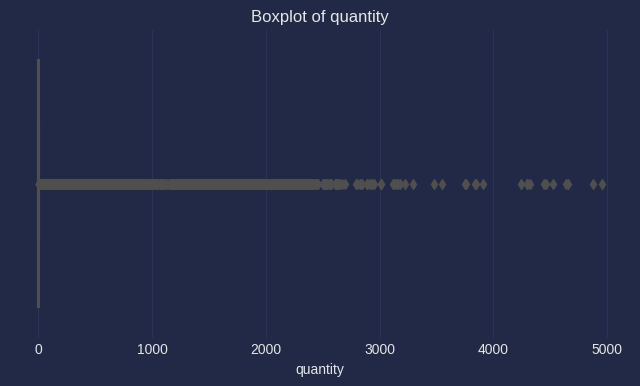

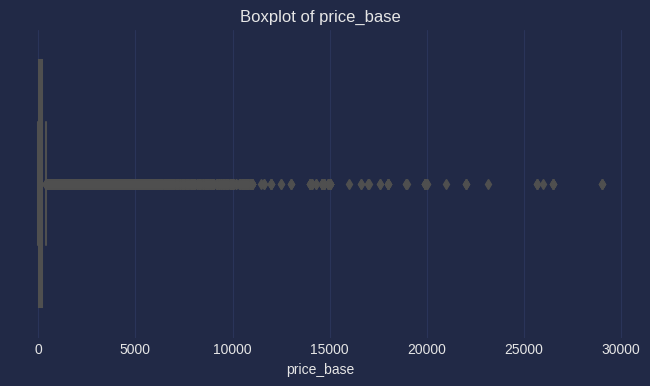

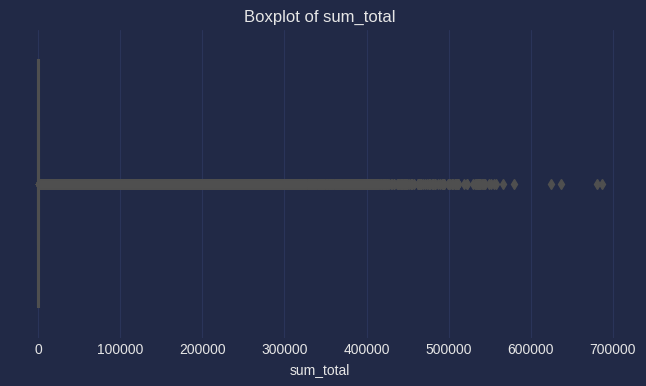

In [15]:
numeric_cols = ['quantity', 'price_base', 'sum_total']  # bỏ store_id nếu không muốn

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_sales[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


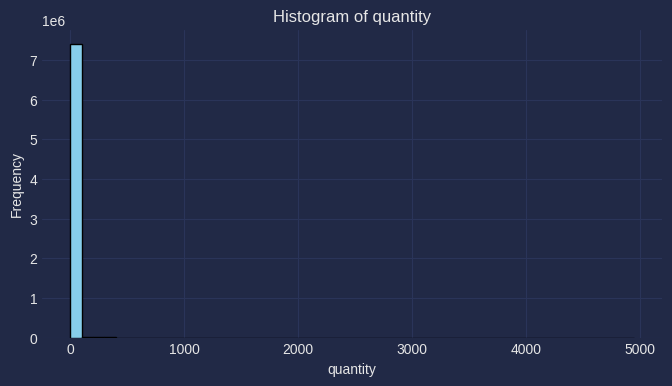

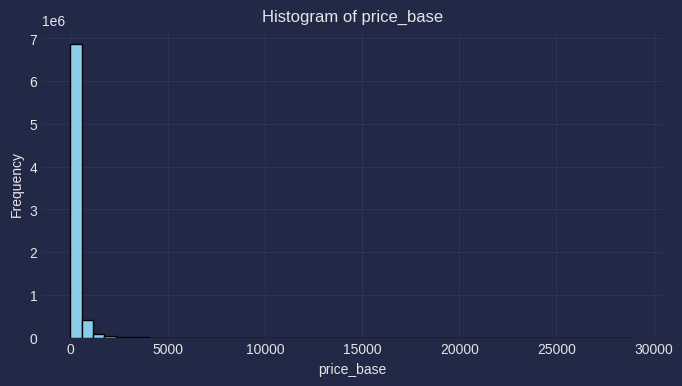

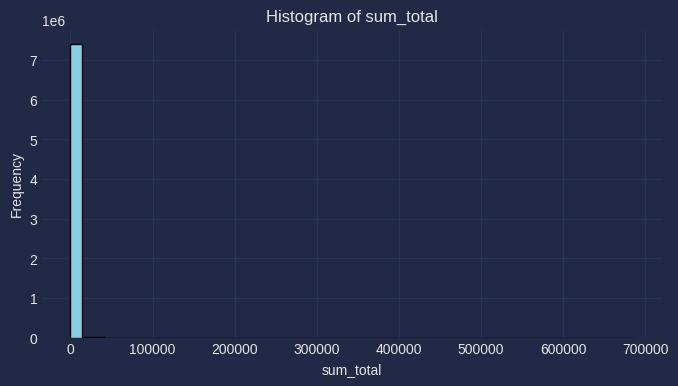

In [16]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    df_sales[col].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Online
chứa tổng hợp doanh số bán hàng online theo cửa hàng cho những ngày cụ thể.
  
* date: Ngày bán hàng
* item_id: Mã định danh duy nhất cho từng sản phẩm
* quantity: Tổng số lượng sản phẩm được bán mỗi ngày (trực tuyến)
* price_base: Giá bán trung bình mỗi ngày
* sum_total: Tổng số tiền bán hàng hàng ngày
* store_id: Số cửa hàng

In [17]:
df_online.head()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,4aa8dbe05246,3.0000,12.4000,37.2100,1
1,2023-08-04,4e0fbcf99cf9,2.0000,56.2700,112.5400,1
2,2023-08-04,2e008b673129,2.0000,56.2700,112.5400,1
3,2023-08-04,49db9c973903,1.0000,29.9400,29.9400,1
4,2023-08-04,9d6072422e8e,1.0000,80.1000,80.1000,1


In [18]:
df_online.describe(include="all")

,date,item_id,quantity,price_base,sum_total,store_id
count,1123412,1123412,1123412.0000,1123412.0000,1123412.0000,1123412.0000
unique,NaN,18405,NaN,NaN,NaN,NaN
top,NaN,a162df3be29c,NaN,NaN,NaN,NaN
freq,NaN,1047,NaN,NaN,NaN,NaN
mean,2023-10-25 13:29:06.836957184,NaN,2.1948,149.7957,225.9123,1.6594
min,2022-08-28 00:00:00,NaN,0.0020,-8458.3300,-341.8800,1.0000
25%,2023-03-25 00:00:00,NaN,1.0000,43.3400,61.4800,1.0000
50%,2023-12-19 00:00:00,NaN,1.0000,78.6950,110.9600,1.0000
75%,2024-05-09 00:00:00,NaN,2.0000,169.2625,222.9000,1.0000
max,2024-09-26 00:00:00,NaN,999.0000,12171.6200,43556.4400,4.0000


### Nhận xét điểm bất thường :
  * "Quantity" có giá trị âm (min=0.002) : Số lượng sản phẩm bán ra không thể là số 0 
  * "Price_base" có giá trị âm lớn (min=-8458.3300) : Giá sản phẩm không thể âm => lỗi ghi hoặc đơn vị tính sai
  * "sum_total: có giá trị âm (min=-341.8800) : Tổng tiền (quantity x price_base) âm => Kết quả không hợp lý

In [19]:
# kiem tra missing value
df_online.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

In [20]:
#kiem tra trung lap
df_online.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
2350897    False
2350898    False
2350899    False
2350900    False
2350901    False
Length: 1123412, dtype: bool

In [21]:
# so luong trung lap
df_online.duplicated().sum()

0

In [22]:
# xoa trung lap
df_online.drop_duplicates()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,4aa8dbe05246,3.0000,12.4000,37.2100,1
1,2023-08-04,4e0fbcf99cf9,2.0000,56.2700,112.5400,1
2,2023-08-04,2e008b673129,2.0000,56.2700,112.5400,1
3,2023-08-04,49db9c973903,1.0000,29.9400,29.9400,1
4,2023-08-04,9d6072422e8e,1.0000,80.1000,80.1000,1
...,...,...,...,...,...,...
2350897,2024-09-26,039823e72e87,1.0000,121.6500,121.6500,4
2350898,2024-09-26,5879ed009378,1.3300,127.8300,170.0100,4
2350899,2024-09-26,1b7358178593,4.0180,41.3600,166.1900,4
2350900,2024-09-26,1218d0240db0,2.0000,14.6300,29.2600,4


In [23]:
# hien thi cac gia tri khong hop ly
df_online[(df_online['quantity'] <= 0) | (df_online['price_base'] <= 0) | (df_online['sum_total'] <= 0)]

,date,item_id,quantity,price_base,sum_total,store_id
48088,2023-09-30,f97e09465bd9,0.0040,-110.0000,-0.4400,1
80034,2023-10-30,95f7fc6882d6,0.0400,-54.5000,-2.1800,1
444802,2024-09-19,b178700122d3,0.0530,-452.2600,-23.9700,1
1698296,2022-09-12,44c942fe217c,3.0000,-113.9600,-341.8800,1
1789380,2022-11-23,0f6c32f3819f,0.1400,-12.6400,-1.7700,1
1910730,2023-02-19,e6a089921dee,0.0060,-8458.3300,-50.7500,1


In [24]:
# Xoa cac gia tri bat thuong
mask_online = (df_online['quantity'] <= 0) | (df_online['price_base'] <= 0) | (df_online['sum_total'] <= 0)
df_online.drop(df_online[mask_online].index, axis=0 , inplace=True )

In [25]:
# hien thi cac gia tri khong hop ly
df_online[(df_online['quantity'] <= 0) | (df_online['price_base'] <= 0) | (df_online['sum_total'] <= 0)]

,date,item_id,quantity,price_base,sum_total,store_id


# Actual_Matrix
Chứa danh sách các sản phẩm có sẵn trong cửa hàng
* item_id: Mã định danh duy nhất cho mỗi sản phẩm
* date: Ngày sản phẩm xuất hiện lần cuối trong ma trận hiện tại
* store_id: Số cửa hàng

## Clean Actual_Matrix

In [26]:
df_actual_matrix.head()

,item_id,date,store_id
0,c578da8e8841,2019-10-17,1
1,4dd2b686802c,2019-10-17,1
2,16ade2e3fca9,2019-10-17,1
3,f4eb16dab09e,2019-10-17,1
4,ab1384c2af6d,2020-05-31,1


In [27]:
# Kiem tra missing value
df_actual_matrix.isna().sum()

item_id     0
date        0
store_id    0
dtype: int64

In [28]:
df_actual_matrix.describe(include="all")

,item_id,date,store_id
count,35202,35202,35202.0000
unique,15398,NaN,NaN
top,19c110a2922d,NaN,NaN
freq,4,NaN,NaN
mean,NaN,2023-01-06 20:34:43.790693632,2.4656
min,NaN,2019-10-17 00:00:00,1.0000
25%,NaN,2022-03-18 00:00:00,1.0000
50%,NaN,2023-12-13 00:00:00,2.0000
75%,NaN,2024-02-14 00:00:00,4.0000
max,NaN,2024-09-26 00:00:00,4.0000


In [29]:
df_actual_matrix.duplicated().sum()

0

In [30]:
# Them một cột mới tên "is_available"→ Mục đích: đánh dấu các dòng này là "có hàng", hoặc "sẵn sàng bán".
df_actual_matrix['is_available'] = True

In [31]:
# Gop bang sales va actual_matrix


In [32]:
df_sales_merged_actual_matrix = pd.merge(df_sales, df_actual_matrix, on=['date', 'item_id', 'store_id'], how='left')
df_sales_merged_actual_matrix

#how='left': giữ nguyên tất cả dòng của df_sales, và chỉ nối thông tin từ df_actual_matrix nếu khớp.
#Nếu không khớp → cột is_available sẽ bị NaN (giá trị thiếu).

,date,item_id,quantity,price_base,sum_total,store_id,is_available
0,2023-08-04,293375605257,1.0000,47.8600,47.8600,1,NaN
1,2023-08-04,a66fdf2c0ae7,3.0000,49.6000,148.8000,1,NaN
2,2023-08-04,daa46ef49b7a,0.8220,379.0000,311.5400,1,NaN
3,2023-08-04,a3b49c1bf758,1.0000,129.0000,129.0000,1,NaN
4,2023-08-04,ab611c5cef62,7.0000,79.9000,559.3000,1,NaN
...,...,...,...,...,...,...,...
7423476,2024-09-26,542f4875a846,2.0000,419.9000,839.8000,4,NaN
7423477,2024-09-26,3c7435256b1f,2.0000,299.9000,599.8000,4,NaN
7423478,2024-09-26,87b794255afc,6.0000,499.9000,2999.4000,4,NaN
7423479,2024-09-26,0a832c545a6a,1.0000,189.9000,189.9000,4,NaN


In [33]:
df_sales_merged_actual_matrix.isna().sum()

date                  0
item_id               0
quantity              0
price_base            0
sum_total             0
store_id              0
is_available    7422876
dtype: int64

In [34]:
df_sales_merged_actual_matrix.fillna(False, inplace=True)
df_sales_merged_actual_matrix.isna().sum()

date            0
item_id         0
quantity        0
price_base      0
sum_total       0
store_id        0
is_available    0
dtype: int64

# Merged Sales and Online

In [35]:
df_online.head()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,4aa8dbe05246,3.0000,12.4000,37.2100,1
1,2023-08-04,4e0fbcf99cf9,2.0000,56.2700,112.5400,1
2,2023-08-04,2e008b673129,2.0000,56.2700,112.5400,1
3,2023-08-04,49db9c973903,1.0000,29.9400,29.9400,1
4,2023-08-04,9d6072422e8e,1.0000,80.1000,80.1000,1


In [36]:
#doi ten tranh bi trung voi df_sales_merged_actual_matrix
df_online = df_online.rename(columns={"price_base" : "price_base_online", "sum_total":"sum_total_online"})
df_online["online"] = True

df = pd.merge(df_sales_merged_actual_matrix, df_online, on=['date', 'item_id', 'store_id'], how="outer", suffixes=('_x', '_y'))

#how='outer': giữ tất cả dữ liệu từ cả hai bảng (kể cả nếu không khớp).
#Khi cột trùng tên (ví dụ quantity), Pandas sẽ đặt hậu tố _x, _y:
#quantity_x: từ bảng df_sales_merged_actual_matrix (offline).
#quantity_y: từ bảng df_online (online).

In [37]:
df.head()

,date,item_id,quantity_x,price_base,sum_total,store_id,is_available,quantity_y,price_base_online,sum_total_online,online
0,2022-08-28,001829cb707d,7.0000,134.7600,943.3200,1,False,NaN,NaN,NaN,NaN
1,2022-08-28,001829cb707d,1.0000,148.0000,148.0000,2,False,NaN,NaN,NaN,NaN
2,2022-08-28,0022b986c8f0,2.0000,59.9000,119.8000,1,False,NaN,NaN,NaN,NaN
3,2022-08-28,00274a69c705,1.0000,35.9000,35.9000,2,False,NaN,NaN,NaN,NaN
4,2022-08-28,00274a69c705,5.0000,35.9000,179.5000,3,False,NaN,NaN,NaN,NaN


In [38]:
#gop quantity_x va quantity_y thanh mot cot
df['quantity'] = df[['quantity_x', 'quantity_y']].sum(axis=1) # tính tổng theo hàng (từng dòng quantity_x + quantity_y

In [39]:
#kiem tra missing value
df.isna().sum()

date                       0
item_id                    0
quantity_x            217243
price_base            217243
sum_total             217243
store_id                   0
is_available          217243
quantity_y           6517318
price_base_online    6517318
sum_total_online     6517318
online               6517318
quantity                   0
dtype: int64

In [40]:
df.head()

,date,item_id,quantity_x,price_base,sum_total,store_id,is_available,quantity_y,price_base_online,sum_total_online,online,quantity
0,2022-08-28,001829cb707d,7.0000,134.7600,943.3200,1,False,NaN,NaN,NaN,NaN,7.0000
1,2022-08-28,001829cb707d,1.0000,148.0000,148.0000,2,False,NaN,NaN,NaN,NaN,1.0000
2,2022-08-28,0022b986c8f0,2.0000,59.9000,119.8000,1,False,NaN,NaN,NaN,NaN,2.0000
3,2022-08-28,00274a69c705,1.0000,35.9000,35.9000,2,False,NaN,NaN,NaN,NaN,1.0000
4,2022-08-28,00274a69c705,5.0000,35.9000,179.5000,3,False,NaN,NaN,NaN,NaN,5.0000


In [41]:
df['online'].fillna(False, inplace = True)
df['is_available'].fillna(True, inplace=True)

In [42]:
df.isna().sum()

date                       0
item_id                    0
quantity_x            217243
price_base            217243
sum_total             217243
store_id                   0
is_available               0
quantity_y           6517318
price_base_online    6517318
sum_total_online     6517318
online                     0
quantity                   0
dtype: int64

In [43]:
# dien gia tri bi thieu bang 0
df.fillna(0, inplace=True)
df.isna().sum()

date                 0
item_id              0
quantity_x           0
price_base           0
sum_total            0
store_id             0
is_available         0
quantity_y           0
price_base_online    0
sum_total_online     0
online               0
quantity             0
dtype: int64

Tình huống	Có nên fillna(0) không?

* Cột số lượng bán (quantity_x, quantity_y)	✅ Có → 0 nghĩa là không bán
* Doanh thu, giá bán (sum_total, price_base)	✅ Có nếu dùng cho tính toán
* Cột boolean như online, is_available	    ✅ Dùng fillna(True/False) như bạn đã làm

In [44]:
# gop sum_total lai
df['sum_total_both'] = df[['sum_total','sum_total_online']].sum(axis=1) #tong hang ngang df['summ_total'+'sum_total_online']
df["price_base_both"] = df["sum_total_both"] / df["quantity"]


In [45]:
#Lọc ra các dòng có online == True
df[df['online']==True].head()

,date,item_id,quantity_x,price_base,sum_total,store_id,is_available,quantity_y,price_base_online,sum_total_online,online,quantity,sum_total_both,price_base_both
14,2022-08-28,0082d7c4d384,13.6010,276.4000,3759.3100,1,False,0.8000,237.5000,190.0000,True,14.4010,3949.3100,274.2386
19,2022-08-28,00aa37841bff,4.0000,89.7900,359.1400,1,False,1.0000,58.5500,58.5500,True,5.0000,417.6900,83.5380
30,2022-08-28,01b6310ee3bf,0.0000,0.0000,0.0000,1,True,2.0000,26.0800,52.1600,True,2.0000,52.1600,26.0800
45,2022-08-28,021e0d49cd97,2.0000,199.9000,399.8000,1,False,1.0000,168.7400,168.7400,True,3.0000,568.5400,189.5133
48,2022-08-28,023861d4f02f,1.0000,72.0000,72.0000,1,False,1.0000,34.7800,34.7800,True,2.0000,106.7800,53.3900


In [46]:
#loc cac bang 
df = df[['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity', 'sum_total_both', 'price_base_both']]
df.describe(include="all")

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both
count,7640724,7640724,7640724.0000,7640724,7640724,7640724.0000,7640724.0000,7640724.0000
unique,NaN,28309,NaN,2,2,NaN,NaN,NaN
top,NaN,e5b2b6f57ea7,NaN,False,False,NaN,NaN,NaN
freq,NaN,2569,NaN,7422876,6517318,NaN,NaN,NaN
mean,2023-11-06 11:06:11.422603520,NaN,2.0298,NaN,NaN,5.8119,773.8796,205.0778
min,2022-08-28 00:00:00,NaN,1.0000,NaN,NaN,0.0020,0.0100,0.0050
25%,2023-05-02 00:00:00,NaN,1.0000,NaN,NaN,1.0000,128.1200,59.9000
50%,2023-12-25 00:00:00,NaN,1.0000,NaN,NaN,2.0000,259.8000,109.8000
75%,2024-05-13 00:00:00,NaN,3.0000,NaN,NaN,5.0000,599.7000,199.9000
max,2024-09-26 00:00:00,NaN,4.0000,NaN,NaN,5023.0000,686524.2100,28999.9000


# Clean Markdowns
* cung cấp dữ liệu về các sản phẩm được bán với giá giảm tại mỗi cửa hàng.

* date: Ngày giảm giá
* item_id: Mã định danh duy nhất cho mỗi sản phẩm
* normal_price: Giá thông thường
* price: Giá trong thời gian giảm giá
* quantity: Số lượng bán ra với giá giảm
* store_id: Số cửa hàng

In [47]:
df_markdowns.describe(include="all")

,date,item_id,normal_price,price,quantity,store_id
count,8979,8979,8979.0000,8979.0000,8979.0000,8979.0000
unique,NaN,313,NaN,NaN,NaN,NaN
top,NaN,e7ff6ea67040,NaN,NaN,NaN,NaN
freq,NaN,491,NaN,NaN,NaN,NaN
mean,2023-09-27 17:07:11.807551232,NaN,358.3528,213.2966,3.0705,1.9128
min,2022-08-28 00:00:00,NaN,0.0000,12.5000,0.1150,1.0000
25%,2023-03-16 00:00:00,NaN,189.0000,100.0000,1.0000,1.0000
50%,2023-10-18 00:00:00,NaN,239.0000,150.0000,2.0000,2.0000
75%,2024-04-14 00:00:00,NaN,549.0000,330.0000,4.0000,2.0000
max,2024-09-26 00:00:00,NaN,2790.0000,1380.5000,120.0000,4.0000


### Nhận xét :
- Giá ban đầu thấp hơn giá lúc giảm (min = 0 < 12.5)

In [48]:
df_markdowns.duplicated().sum()

268

In [49]:
df_markdowns.drop_duplicates()

,date,item_id,normal_price,price,quantity,store_id
0,2023-08-01,bc2f82a22e11,189.0000,100.0000,8.0000,1
1,2023-08-01,389412076801,179.0000,100.0000,5.0000,1
2,2023-08-01,0e39cf5d57c1,149.0000,100.0000,5.0000,1
3,2023-08-01,dd94e2bc5601,149.0000,100.0000,1.0000,1
4,2023-08-01,e60d890f2812,369.0000,270.0000,1.0000,1
...,...,...,...,...,...,...
35033,2024-09-26,07605df7333f,199.0000,95.6000,1.0000,4
35034,2024-09-26,d60184cf6ca5,199.0000,119.4000,2.0000,4
35035,2024-09-26,17abde81f33d,549.0000,311.9000,1.0000,4
35036,2024-09-26,4cf0bb777594,569.0000,340.2000,2.0000,4


In [50]:
mask_markdown = (df_markdowns.normal_price <= df_markdowns.price)
df_markdowns[mask_markdown]

,date,item_id,normal_price,price,quantity,store_id
168,2023-09-04,44c942fe217c,195.0000,240.0000,11.0000,1
170,2023-09-04,a9d8c085adc0,270.0000,300.0000,32.0000,1
172,2023-09-04,f611e25fa53a,275.0000,320.0000,13.0000,1
177,2023-09-04,76c18abd8f7c,359.0000,390.0000,7.0000,1
1247,2024-03-11,389412076801,119.0000,120.0000,9.0000,1
1251,2024-03-12,389412076801,119.0000,120.0000,3.0000,1
1254,2024-03-13,389412076801,119.0000,120.0000,3.0000,1
1260,2024-03-14,389412076801,119.0000,120.0000,2.0000,1
1307,2024-03-21,389412076801,119.0000,120.0000,1.0000,1
15827,2023-01-09,291d60da77b1,332.9000,339.9000,2.0000,1


In [51]:
df_markdowns.drop(df_markdowns[mask_markdown].index, axis=0 , inplace=True)

In [52]:
df_markdowns.isna().sum()

date            0
item_id         0
normal_price    0
price           0
quantity        0
store_id        0
dtype: int64

In [53]:
df_markdowns

,date,item_id,normal_price,price,quantity,store_id
0,2023-08-01,bc2f82a22e11,189.0000,100.0000,8.0000,1
1,2023-08-01,389412076801,179.0000,100.0000,5.0000,1
2,2023-08-01,0e39cf5d57c1,149.0000,100.0000,5.0000,1
3,2023-08-01,dd94e2bc5601,149.0000,100.0000,1.0000,1
4,2023-08-01,e60d890f2812,369.0000,270.0000,1.0000,1
...,...,...,...,...,...,...
35033,2024-09-26,07605df7333f,199.0000,95.6000,1.0000,4
35034,2024-09-26,d60184cf6ca5,199.0000,119.4000,2.0000,4
35035,2024-09-26,17abde81f33d,549.0000,311.9000,1.0000,4
35036,2024-09-26,4cf0bb777594,569.0000,340.2000,2.0000,4


# Store

In [54]:
df = df.merge(df_stores, how='left', left_on=["store_id"], right_on=["store_id"])
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,format,city,area
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,Format-1,City1,1500
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,Format-6,City1,210
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,Format-1,City1,1500
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,Format-6,City1,210
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,Format-7 express,City2,109


In [55]:
df.drop(["format","area"],axis=1, inplace=True)
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2


# Clean discount_history
* Bao gồm dữ liệu khuyến mại lịch sử cho từng cửa hàng cụ thể.

* date: Ngày
* item_id: Mã định danh duy nhất cho từng sản phẩm
* sale_price_before_promo: Giá trước khi thời gian khuyến mại bắt đầu
* sale_price_time_promo: Giá trong thời gian khuyến mại
* promo_type_code: Loại mã khuyến mại
* doc_id: Số tài liệu khuyến mại
* number_disc_day: Số ngày tuần tự của thời gian khuyến mại hiện tại
* store_id: Số cửa hàng

In [56]:
df_discounts_history.describe(include="all")

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
count,3746744,3746744,3746744.0000,3746744.0000,3428898.0000,3746744,3746744.0000,3746744.0000
unique,NaN,16081,NaN,NaN,NaN,13763,NaN,NaN
top,NaN,99d388c37359,NaN,NaN,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,NaN,NaN
freq,NaN,34108,NaN,NaN,NaN,196121,NaN,NaN
mean,2024-06-17 11:33:20.464616960,NaN,425.3020,334.0184,5.6623,NaN,286.3346,2.0350
min,2022-08-28 00:00:00,NaN,0.0000,0.0000,1.0000,NaN,1.0000,1.0000
25%,2023-05-01 00:00:00,NaN,84.9000,69.9000,5.0000,NaN,4.0000,1.0000
50%,2024-01-13 00:00:00,NaN,179.9000,149.9000,5.0000,NaN,8.0000,2.0000
75%,2024-06-18 00:00:00,NaN,499.9000,389.9000,6.0000,NaN,13.0000,3.0000
max,2045-12-31 00:00:00,NaN,16999.9000,15999.9000,44.0000,NaN,8766.0000,4.0000


In [57]:
df_discounts_history.duplicated().sum()

0

In [58]:
mask = (df_discounts_history.sale_price_before_promo <= df_discounts_history.sale_price_time_promo) | (df_discounts_history.sale_price_before_promo <= 0) | (df_discounts_history.sale_price_time_promo < 0) | (df_discounts_history.date > df_test.date.max())
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
3648341,2022-08-28,68348aae54c8,99.9000,99.9000,10.0000,12f93be4-245e-11ed-ad4d-005056861040,6.0000,1
3648439,2022-08-28,aa6d09435319,799.9000,799.9000,10.0000,12f93be4-245e-11ed-ad4d-005056861040,6.0000,1
3648451,2022-08-28,7428830d55b6,279.9000,279.9000,10.0000,12f93be5-245e-11ed-ad4d-005056861040,6.0000,1
3648481,2022-08-28,8250099a8aff,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,240.0000,1
3648482,2022-08-28,23b18d1f7da9,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,240.0000,1
...,...,...,...,...,...,...,...,...
11420928,2045-12-31,23b18d1f7da9,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420929,2045-12-31,e5b2b6f57ea7,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420930,2045-12-31,2c007023f650,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420931,2045-12-31,9f716dce9a57,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4


* Ngày khuyến mãi nằm ngoài khoảng thời gian test → có thể là dữ liệu lỗi hoặc ngoài phạm vi dự báo

In [59]:
# Xoa diem bat thuong 
df_discounts_history.drop(df_discounts_history[mask].index, axis=0, inplace=True)

In [60]:
#Kiem tra missing value
df_discounts_history.isna().sum()

date                           0
item_id                        0
sale_price_before_promo        0
sale_price_time_promo          0
promo_type_code            54126
doc_id                         0
number_disc_day                0
store_id                       0
dtype: int64

In [61]:
print(df_test.date.max())
print(df_test.date.min())

2024-10-26 00:00:00
2024-09-27 00:00:00


In [62]:
# lọc dữ liệu khuyến mãi nằm trong khoảng thời gian của tập test
mask = ((df_discounts_history.date >= df_test.date.min()) & (df_discounts_history.date <= df_test.date.max()))
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
5316258,2024-09-27,8ddf239d0d9b,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1
5316259,2024-09-27,ebf2a6dedec8,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1
5316260,2024-09-27,778fae444c09,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1
5316261,2024-09-27,fcd33abe242f,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1
5316262,2024-09-27,6ab1190bdc2d,389.9000,249.9000,5.0000,45e0c4c5-7b0f-11ef-bb95-005056afbcf1,3.0000,1
...,...,...,...,...,...,...,...,...
11373844,2024-10-25,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,38.0000,4
11373853,2024-10-25,6410dbb30c90,399.9000,299.9000,5.0000,9a579259-7720-11ef-bb94-005056afbcf1,36.0000,4
11373862,2024-10-26,9ee5eded00cf,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4
11373863,2024-10-26,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4


In [63]:
# Ty le giam gia
df_discounts_history["discount_percentage"] = (df_discounts_history["sale_price_before_promo"] - df_discounts_history["sale_price_time_promo"])  / df_discounts_history["sale_price_before_promo"]
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id,discount_percentage
5316258,2024-09-27,8ddf239d0d9b,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1,0.1430
5316259,2024-09-27,ebf2a6dedec8,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1,0.1430
5316260,2024-09-27,778fae444c09,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1,0.0835
5316261,2024-09-27,fcd33abe242f,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1,0.0835
5316262,2024-09-27,6ab1190bdc2d,389.9000,249.9000,5.0000,45e0c4c5-7b0f-11ef-bb95-005056afbcf1,3.0000,1,0.3591
...,...,...,...,...,...,...,...,...,...
11373844,2024-10-25,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,38.0000,4,0.2001
11373853,2024-10-25,6410dbb30c90,399.9000,299.9000,5.0000,9a579259-7720-11ef-bb94-005056afbcf1,36.0000,4,0.2501
11373862,2024-10-26,9ee5eded00cf,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4,0.2001
11373863,2024-10-26,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4,0.2001


# Clean price_history

In [64]:
df_price_history.describe(include="all")

,date,item_id,price,code,store_id
count,698626,698626,698626.0000,698626.0000,698626.0000
unique,NaN,37624,NaN,NaN,NaN
top,NaN,f1749f4b783b,NaN,NaN,NaN
freq,NaN,559,NaN,NaN,NaN
mean,2023-10-14 19:36:05.247786240,NaN,673.7037,551854652.4888,1.9702
min,2022-08-28 00:00:00,NaN,0.0000,1.0000,1.0000
25%,2023-04-21 00:00:00,NaN,65.9000,1.0000,1.0000
50%,2023-11-06 00:00:00,NaN,149.9000,10.0000,2.0000
75%,2024-04-11 00:00:00,NaN,359.9000,29.0000,3.0000
max,2024-09-26 00:00:00,NaN,118496741.2200,9999999999.0000,4.0000


In [65]:
mask = (df_price_history.price <= 0)
df_price_history[mask]

,date,item_id,price,code,store_id
1,2023-08-01,bf43a9d3ae13,0.0000,9999999999,1
4,2023-08-01,b791e8c9347c,0.0000,1,1
7,2023-08-01,5daf42ae04ce,0.0000,1,1
11,2023-08-01,6f0d7697f5a2,0.0000,1,1
12,2023-08-01,5f315be0c428,0.0000,1,1
...,...,...,...,...,...
1884871,2024-09-26,668ce7bfa0f1,0.0000,7,4
1884891,2024-09-26,35f68d6f20c5,0.0000,7,4
1884931,2024-09-26,605f81dd80bd,0.0000,9999999999,4
1884932,2024-09-26,0dd06fe6d26b,0.0000,9999999999,4


In [66]:
# Xoa truong hop bat hop ly
df_price_history.drop(df_price_history[mask].index, axis=0, inplace=True)

# Merge price vao DF

In [67]:
df_price_history.describe(include="all")

,date,item_id,price,code,store_id
count,636967,636967,636967.0000,636967.0000,636967.0000
unique,NaN,32336,NaN,NaN,NaN
top,NaN,f1749f4b783b,NaN,NaN,NaN
freq,NaN,559,NaN,NaN,NaN
mean,2023-10-08 12:37:15.597134592,NaN,738.9189,12543834.0975,1.9620
min,2022-08-28 00:00:00,NaN,0.0100,1.0000,1.0000
25%,2023-04-05 00:00:00,NaN,84.9000,1.0000,1.0000
50%,2023-10-29 00:00:00,NaN,169.9000,9.0000,2.0000
75%,2024-04-10 00:00:00,NaN,399.0000,23.0000,3.0000
max,2024-09-26 00:00:00,NaN,118496741.2200,9999999999.0000,4.0000


In [68]:
df_price_history.duplicated(subset=['item_id', 'store_id', 'date']).sum()

78219

In [69]:
df_price_history.duplicated().sum()

17403

In [70]:
#loại bỏ các dòng trùng lặp, chỉ giữ lại dòng cuối cùng 
df_price_history = df_price_history.drop_duplicates(subset=['item_id', 'store_id', 'date'], keep='last')

In [71]:
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2


In [72]:
# gán toàn bộ cột price trong DataFrame df thành giá trị thiếu (NA)
df['price'] = pd.NA
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,<NA>
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,<NA>
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,<NA>
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,<NA>
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,<NA>


In [73]:
# Tìm giá gần nhất trong quá khứ
df_price_history['date'].head()

3065   2023-08-04
3068   2023-08-04
3078   2023-08-04
3083   2023-08-04
3088   2023-08-04
Name: date, dtype: datetime64[ns]

In [74]:
df['date'].iloc[0]

Timestamp('2022-08-28 00:00:00')

In [75]:
# Lọc giá trị tối đa date <= row['date'] và gộp lại với df_price_history
price_history_filtered = df_price_history[df_price_history['date'] <= df['date'].iloc[0]]
price_history_filtered

,date,item_id,price,code,store_id
643657,2022-08-28,3e2949d4dec7,269.9000,11,1
643658,2022-08-28,5b802c30f302,36.9000,1,1
643659,2022-08-28,a5024a82accd,36.9000,1,1
643660,2022-08-28,33fe7c48ff4e,36.9000,1,1
643661,2022-08-28,155f0a7b1cba,36.9000,1,1
643662,2022-08-28,c20fd8f9f2a7,249.9000,11,1
643663,2022-08-28,bde3aaf94f64,299.9000,11,1
643664,2022-08-28,7e2b7f919028,859.9000,11,1
643665,2022-08-28,1408497ade4a,36.9000,1,1
643666,2022-08-28,2472c6e0775d,36.9000,1,1


In [76]:
latest_prices = price_history_filtered.groupby(['item_id', 'store_id'])['date'].max().reset_index()
latest_prices

,item_id,store_id,date
0,0633afaab3d8,2,2022-08-28
1,105b871b4f93,2,2022-08-28
2,105b871b4f93,3,2022-08-28
3,1408497ade4a,1,2022-08-28
4,155f0a7b1cba,1,2022-08-28
5,18dd7b067651,2,2022-08-28
6,1b63171e3b08,1,2022-08-28
7,1c788631d794,1,2022-08-28
8,1f44298be235,1,2022-08-28
9,2078668639b4,1,2022-08-28


In [77]:
latest_prices = pd.merge(latest_prices, df_price_history, on=['item_id', 'store_id', 'date'], how='left')
latest_prices

,item_id,store_id,date,price,code
0,0633afaab3d8,2,2022-08-28,79.9000,11
1,105b871b4f93,2,2022-08-28,669.0000,1
2,105b871b4f93,3,2022-08-28,679.0000,1
3,1408497ade4a,1,2022-08-28,36.9000,1
4,155f0a7b1cba,1,2022-08-28,36.9000,1
5,18dd7b067651,2,2022-08-28,85.9000,11
6,1b63171e3b08,1,2022-08-28,119.9000,1
7,1c788631d794,1,2022-08-28,36.9000,1
8,1f44298be235,1,2022-08-28,99.9000,1
9,2078668639b4,1,2022-08-28,36.9000,1


In [78]:
# Lọc giá trị tối thiểu date > row['date'] và gộp lại với df_]price_history
price_history_filtered_next = df_price_history[df_price_history['date'] > df['date'].iloc[0]]
earliest_prices = price_history_filtered_next.groupby(['item_id', 'store_id'])['date'].min().reset_index()
earliest_prices = pd.merge(earliest_prices, df_price_history, on=['item_id', 'store_id', 'date'], how='left')
earliest_prices

,item_id,store_id,date,price,code
0,00061dc0a8a5,1,2024-03-31,12.9000,7
1,00061dc0a8a5,2,2024-03-31,12.9000,7
2,00061dc0a8a5,3,2023-11-15,34.9000,1
3,00061dc0a8a5,4,2024-03-31,12.9000,7
4,0010323c7e62,1,2024-01-26,1990.0000,1
...,...,...,...,...,...
80436,fffd09fe4cfb,4,2024-04-23,199.9000,1
80437,fffddcc5521e,1,2023-01-12,299.0000,29
80438,fffddcc5521e,2,2022-10-12,309.0000,9
80439,fffddcc5521e,3,2023-07-18,379.0000,1


In [79]:
# Merge kết quả để có cột giá trị price cho mỗi item_id tại store_id
df= pd.merge(df, latest_prices[['item_id', 'store_id','price']], on=['item_id', 'store_id'], how='left', suffixes=('', '_latest')) #xử lý các cột bị trùng tên giữa hai DataFrame khi gộp (merge).
df= pd.merge(df, earliest_prices[['item_id' , 'store_id', 'price']], on = ['item_id', 'store_id'], how='left', suffixes=('','_earliest'))

# # Sử dụng điều kiện để chọn giá trị cuối cùng (price_latest nếu không có giá trị, chọn price_earliest)
# df['price'] = df['price_latest'].fillna(df['price_earliest'])

# # Xóa các cột tạm thời
# df.drop(['price_latest', 'price_earliest'], axis=1, inplace=True)

In [80]:
print(df.columns)

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'price_latest', 'price_earliest'],
      dtype='object')


In [81]:
df

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price,price_latest,price_earliest
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,<NA>,NaN,119.9000
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,<NA>,NaN,149.9000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,<NA>,NaN,69.9000
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,<NA>,NaN,NaN
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7640719,2024-09-26,ffea55e3589f,1,False,False,0.7600,379.9200,499.8947,Div1,City1,<NA>,NaN,799.9000
7640720,2024-09-26,ffea55e3589f,2,False,False,0.1050,75.5100,719.1429,Div2,City1,<NA>,NaN,799.9000
7640721,2024-09-26,ffea55e3589f,4,False,False,0.4990,249.4500,499.8998,Div1,City3,<NA>,NaN,759.0000
7640722,2024-09-26,fffb04d8e873,1,False,False,4.0000,415.8800,103.9700,Div1,City1,<NA>,NaN,164.9000


In [82]:
df.isna().sum()

date                     0
item_id                  0
store_id                 0
is_available             0
online                   0
quantity                 0
sum_total_both           0
price_base_both          0
division                 0
city                     0
price              7640724
price_latest       7626152
price_earliest      344084
dtype: int64

In [83]:
# Sử dụng điều kiện để chọn giá trị cuối cùng (price_latest nếu không có giá trị -> chọn price_earliest)
df['price'] = df['price_latest'].fillna(df['price_earliest'])

# # Xóa các cột tạm thời
df.drop(['price_latest', 'price_earliest'], axis=1, inplace=True)

In [84]:
# Kiem tra missing value
df.isna().sum()

date                    0
item_id                 0
store_id                0
is_available            0
online                  0
quantity                0
sum_total_both          0
price_base_both         0
division                0
city                    0
price              344084
dtype: int64

In [85]:
df['price'] = df['price'].fillna(df['price_base_both'])

In [86]:
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,119.9000
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000


In [87]:
df.isna().sum()

date               0
item_id            0
store_id           0
is_available       0
online             0
quantity           0
sum_total_both     0
price_base_both    0
division           0
city               0
price              0
dtype: int64

In [88]:
# lọc những dòng mà giá thực tế 
df.loc[df['price'] < df['price_base_both'], 'price'] = df['price_base_both']
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000


# Merge Discount vao df

In [89]:
df_discounts_history.head()

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id,discount_percentage
3648316,2022-08-28,cde97a9ec3ef,729.9000,669.9000,6.0000,89ea9f0c-1c08-11ed-ad4d-005056861040,13.0000,1,0.0822
3648317,2022-08-28,2906fbc9e11c,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1,0.2309
3648318,2022-08-28,c48c3a3d8c01,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1,0.2309
3648319,2022-08-28,f85243ca61e6,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1,0.2309
3648320,2022-08-28,27ce75534065,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1,0.2309


In [90]:
#  lưu lại danh sách các cột hiện có của df de giu dung thu tu
columns = df.columns.to_list()

df=df.merge(
    df_discounts_history,
    left_on=['item_id', 'store_id', 'date'],
    right_on=['item_id', 'store_id', 'date'],
    how='left',
    suffixes=('','_price')
)
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,discount_percentage
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
df=df[columns + ['discount_percentage', 'number_disc_day']]
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price,discount_percentage,number_disc_day
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600,NaN,NaN
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000,NaN,NaN
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000,NaN,NaN
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000,NaN,NaN
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000,NaN,NaN


In [92]:
df = df.fillna(0)

# Merge store, discount to test

## test.csv
* Mục đích: Bao gồm các trường hợp thử nghiệm mà người tham gia được yêu cầu dự đoán.

* row_id: Mã định danh duy nhất cho mỗi bản ghi
* item_id: Mã định danh duy nhất cho mỗi sản phẩm
* store_id: Số cửa hàng
* date: Ngày dự báo sẽ được thực hiện

In [93]:
df_test

,item_id,store_id,date
row_id,,,
0,c578da8e8841,1,2024-09-27
1,c578da8e8841,1,2024-09-28
2,c578da8e8841,1,2024-09-29
3,c578da8e8841,1,2024-09-30
4,c578da8e8841,1,2024-10-01
...,...,...,...
883675,1fea1f54a7ec,4,2024-10-22
883676,1fea1f54a7ec,4,2024-10-23
883677,1fea1f54a7ec,4,2024-10-24


In [94]:
columns = df_test.columns.to_list()
df_test = df_test.merge(
    df_discounts_history,
    left_on=['item_id', 'store_id', 'date'],
    right_on=['item_id', 'store_id', 'date'],
    how='left',
    suffixes=('', '_price')
)

df_test = df_test.merge(df_stores, how='left', left_on=["store_id"], right_on=["store_id"])


In [95]:
df_test

,item_id,store_id,date,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,discount_percentage,division,format,city,area
0,c578da8e8841,1,2024-09-27,NaN,NaN,NaN,NaN,NaN,NaN,Div1,Format-1,City1,1500
1,c578da8e8841,1,2024-09-28,NaN,NaN,NaN,NaN,NaN,NaN,Div1,Format-1,City1,1500
2,c578da8e8841,1,2024-09-29,NaN,NaN,NaN,NaN,NaN,NaN,Div1,Format-1,City1,1500
3,c578da8e8841,1,2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,Div1,Format-1,City1,1500
4,c578da8e8841,1,2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,Div1,Format-1,City1,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
883675,1fea1f54a7ec,4,2024-10-22,NaN,NaN,NaN,NaN,NaN,NaN,Div1,MaxiEuro,City3,1887
883676,1fea1f54a7ec,4,2024-10-23,NaN,NaN,NaN,NaN,NaN,NaN,Div1,MaxiEuro,City3,1887
883677,1fea1f54a7ec,4,2024-10-24,NaN,NaN,NaN,NaN,NaN,NaN,Div1,MaxiEuro,City3,1887
883678,1fea1f54a7ec,4,2024-10-25,NaN,NaN,NaN,NaN,NaN,NaN,Div1,MaxiEuro,City3,1887


In [96]:
df_test = df_test[columns+['discount_percentage', 'number_disc_day', 'division', 'city']]
df_test.head()

,item_id,store_id,date,discount_percentage,number_disc_day,division,city
0,c578da8e8841,1,2024-09-27,NaN,NaN,Div1,City1
1,c578da8e8841,1,2024-09-28,NaN,NaN,Div1,City1
2,c578da8e8841,1,2024-09-29,NaN,NaN,Div1,City1
3,c578da8e8841,1,2024-09-30,NaN,NaN,Div1,City1
4,c578da8e8841,1,2024-10-01,NaN,NaN,Div1,City1


In [97]:
df_test.isna().sum()

item_id                     0
store_id                    0
date                        0
discount_percentage    840003
number_disc_day        840003
division                    0
city                        0
dtype: int64

In [98]:
df_test = df_test.fillna(0)

# Clean Catalog
Mục đích: Danh mục sản phẩm có đặc điểm.

* item_id: Mã định danh duy nhất cho từng sản phẩm
* dept_name: Phòng ban sản phẩm (cấp bậc phân cấp)
* class_name: Lớp sản phẩm (cấp bậc phân cấp)
* subclass_name: Lớp con sản phẩm (cấp bậc phân cấp)
* item_type: Loại sản phẩm
* weight_volume: Trọng lượng thể tích
* weight_netto: Trọng lượng tịnh
* fatness: Hàm lượng chất béo

In [99]:
df_catalog = pd.read_csv("/kaggle/input/translate/translated_catalog.csv", index_col=0)

In [100]:
df_catalog.head()

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
Unnamed: 0,,,,,,,,
0,da17e2d5feda,Paper products,Paper products,Wet napkins,NaN,150.0000,NaN,NaN
1,614de2b96018,Paper products,Cotton products,Cotton wheels,NaN,30.0000,NaN,NaN
2,0c1f1f3e3e11,Paper products,Cotton products,Cotton wheels,NaN,NaN,NaN,NaN
3,71a7fa99f005,Home goods,Vessel,COOKWARE,NaN,NaN,NaN,NaN
4,ec1bd4d59fe9,Paper products,Cotton products,Cotton wheels,NaN,30.0000,NaN,NaN


In [101]:
df = df.merge(df_catalog, how='left', left_on=['item_id'], right_on='item_id')
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price,discount_percentage,number_disc_day,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600,0.0000,0.0000,CREAM,CREAM,Drinking cream,Drinking,0.5000,0.5000,10.0000
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000,0.0000,0.0000,CREAM,CREAM,Drinking cream,Drinking,0.5000,0.5000,10.0000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000,0.0000,0.0000,"Spices, seasoning",Monitoring,Monitoring,"Spices, seasoning",0.0200,0.0200,NaN
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000,0.0000,0.0000,Sweet flour products,Biscuit,The cookies are packaged,Biscuit,0.1300,0.1300,NaN
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000,0.0000,0.0000,Sweet flour products,Biscuit,The cookies are packaged,Biscuit,0.1300,0.1300,NaN


In [102]:
df_test = df_test.merge(df_catalog, how='left', left_on='item_id', right_on='item_id')
df_test.shape

(883680, 14)

# Tìm kiếm các giá trị bị thiếu trong tập dữ liệu sales va test

In [103]:
df.isna().sum()

date                         0
item_id                      0
store_id                     0
is_available                 0
online                       0
quantity                     0
sum_total_both               0
price_base_both              0
division                     0
city                         0
price                        0
discount_percentage          0
number_disc_day              0
dept_name                37373
class_name               37373
subclass_name            37373
item_type               700250
weight_volume          1482521
weight_netto           1154675
fatness                6972777
dtype: int64

In [104]:
def get_columns_with_nan(df): 
    return df.columns[df.isna().sum() > 0]

cols = get_columns_with_nan(df)

df[cols].isna().sum()*100/len(df)

dept_name        0.4891
class_name       0.4891
subclass_name    0.4891
item_type        9.1647
weight_volume   19.4029
weight_netto    15.1121
fatness         91.2581
dtype: float64

In [105]:
df_test[cols].isna().sum()*100/len(df_test)

dept_name        6.3485
class_name       6.3485
subclass_name    6.3485
item_type       13.2469
weight_volume   21.9514
weight_netto    16.2446
fatness         94.7787
dtype: float64

### Nhận xét: 
- Vì fatness có tỉ lệ missing value -> Rất cao – gần như toàn bộ dữ liệu bị thiếu
- Không có đủ dữ liệu để dùng cột này trong phân tích hoặc mô hình hóa.
-> không quan trọng


In [106]:
# Xoa fatness
df = df.drop(['fatness'], axis=1)
df_test = df_test.drop(['fatness'], axis=1)

In [107]:
df.isna().sum()

date                         0
item_id                      0
store_id                     0
is_available                 0
online                       0
quantity                     0
sum_total_both               0
price_base_both              0
division                     0
city                         0
price                        0
discount_percentage          0
number_disc_day              0
dept_name                37373
class_name               37373
subclass_name            37373
item_type               700250
weight_volume          1482521
weight_netto           1154675
dtype: int64

In [108]:
df_test.isna().sum()

item_id                     0
store_id                    0
date                        0
discount_percentage         0
number_disc_day             0
division                    0
city                        0
dept_name               56100
class_name              56100
subclass_name           56100
item_type              117060
weight_volume          193980
weight_netto           143550
dtype: int64

## Filling missing value

In [109]:
def fill_catalog(dataframe, item_name='other'):
    dataframe.dept_name = dataframe.dept_name.fillna("other")
    dataframe.class_name = dataframe.class_name.fillna("other")
    dataframe.subclass_name = dataframe.subclass_name.fillna("other")
    dataframe.item_type = dataframe.item_type.fillna("other")
    return dataframe
df = fill_catalog(df, item_name='other')
df_test = fill_catalog(df_test, item_name='other')

In [110]:
cols = get_columns_with_nan(df)
cols

Index(['weight_volume', 'weight_netto'], dtype='object')

## Điền vào các tính năng weight_volume và weight_netto

In [111]:
def weight_fill_nan(dataframe):
    dataframe.weight_volume = dataframe.groupby(by=["item_id", "dept_name", "class_name", "subclass_name", "item_type"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["item_id", "dept_name", "class_name", "subclass_name", "item_type"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name", "subclass_name", "item_type"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name", "subclass_name", "item_type"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name", "subclass_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name", "subclass_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    return dataframe

train_index = len(df)
test_index = len(df_test)

all_data = pd.concat([df, df_test], axis=0)

all_data = weight_fill_nan(all_data)
df = all_data.iloc[:train_index]
df_test = all_data.iloc[train_index:test_index+train_index]

In [112]:
df.isna().sum()

date                        0
item_id                     0
store_id                    0
is_available                0
online                      0
quantity                    0
sum_total_both              0
price_base_both             0
division                    0
city                        0
price                       0
discount_percentage         0
number_disc_day             0
dept_name                   0
class_name                  0
subclass_name               0
item_type                   0
weight_volume          125400
weight_netto            95946
dtype: int64

- weight_volume: Trọng lượng thể tích
- weight_netto: Trọng lượng tịnh

In [113]:
df = df.fillna(-1) # dien -1 la khong xac dinh
df[cols].isna().sum()*100/len(df)

weight_volume   0.0000
weight_netto    0.0000
dtype: float64

In [114]:
df_test = df_test.fillna(-1)
df_test[cols].isna().sum()*100/len(df_test)

weight_volume   0.0000
weight_netto    0.0000
dtype: float64

In [115]:
df_price_history.sort_values(by=['store_id', 'item_id', 'date'], inplace=True)
df_price_history

,date,item_id,price,code,store_id
103430,2024-03-31,00061dc0a8a5,12.9000,7,1
77718,2024-01-26,0010323c7e62,1990.0000,1,1
131332,2024-06-18,0010323c7e62,2199.9000,1,1
670135,2022-11-02,00179dda14f8,669.9000,1,1
688917,2022-12-07,00179dda14f8,664.0000,1,1
...,...,...,...,...,...
1779744,2023-12-19,fff9aabc5046,2499.9000,31,4
1822182,2024-04-09,fff9aabc5046,2999.9000,1,4
1865497,2024-08-07,fffb04d8e873,104.9000,24,4
1827260,2024-04-23,fffd09fe4cfb,199.9000,1,4


Tạo một từ điển (price_dict) để lưu lịch sử giá theo từng store_id và item_id.


In [116]:
from collections import defaultdict
#tạo ra một dictionary mà giá trị mặc định là một danh sách rỗng [] nếu key chưa tồn tại.

price_dict = defaultdict(list)
for row in df_price_history.itertuples(index=False):
    key = (row.store_id, row.item_id)                #itertuples() giúp truy cập nhanh từng dòng, mỗi dòng là một tuple.
    price_dict[key].append((row.date, row.price))                                              #index=False: không lấy chỉ số dòng (index), chỉ lấy các cột dữ liệu.



Tìm và gán giá gần nhất (trước hoặc đúng ngày) cho mỗi dòng trong df_test từ lịch sử giá df_price_history, đã lưu trong price_dict.

In [117]:
from bisect import bisect_right
def get_latest_price(key, date):
    entries = price_dict.get(key, [])  # Lấy danh sách (date, price) của sản phẩm tại cửa hàng
    dates = [d for d, _ in entries]    # Trích danh sách các ngày
    idx = bisect_right(dates, date) - 1  # Tìm index của ngày gần nhất trước hoặc bằng ngày cần
    if idx >= 0:
        return entries[idx][1]        # Trả về giá tương ứng
    return None                       # Nếu không có ngày nào phù hợp

# Áp dụng từng dòng
df_test['price'] = [
    get_latest_price((row.store_id, row.item_id), row.date)
    for row in df_test.itertuples(index=False)
]

In [118]:
# Kiem tra missing value
df_test.isna().sum()

date                       0
item_id                    0
store_id                   0
is_available               0
online                     0
quantity                   0
sum_total_both             0
price_base_both            0
division                   0
city                       0
price                  57180
discount_percentage        0
number_disc_day            0
dept_name                  0
class_name                 0
subclass_name              0
item_type                  0
weight_volume              0
weight_netto               0
dtype: int64

In [119]:
df.isna().sum()

date                   0
item_id                0
store_id               0
is_available           0
online                 0
quantity               0
sum_total_both         0
price_base_both        0
division               0
city                   0
price                  0
discount_percentage    0
number_disc_day        0
dept_name              0
class_name             0
subclass_name          0
item_type              0
weight_volume          0
weight_netto           0
dtype: int64

In [120]:
df_test = df_test.fillna(-1) #khong xac dinh

# Data visualization

## Quantity 
### Phân phối số lượng

Text(0.5, 1.0, 'Quantity distribution')

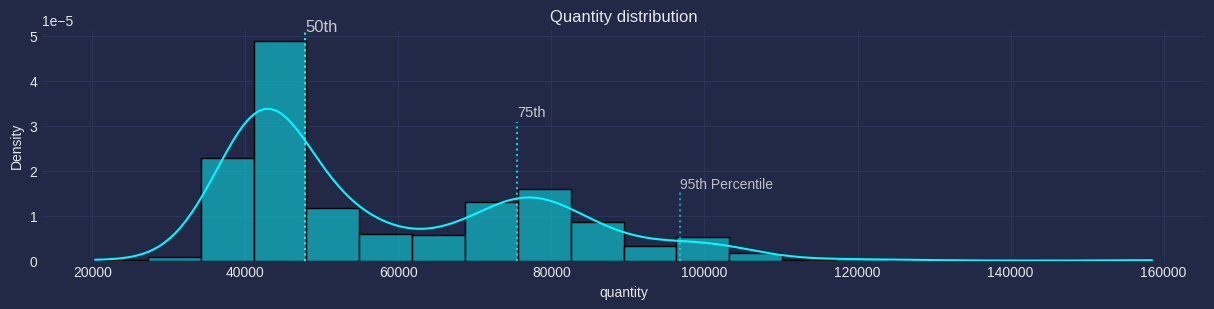

In [121]:
#tổng số lượng (quantity) bán ra theo từng ngày 
aux = df.groupby('date', as_index=False).quantity.sum() #as_index=False: kết quả trả về sẽ không dùng date làm chỉ số (index)
plt.figure(figsize=(15,3))
sns.histplot(data=aux, x='quantity', kde=True, stat='density')
quant_50 = aux.quantity.quantile(0.5)
quant_75 = aux.quantity.quantile(0.75)
quant_95 = aux.quantity.quantile(0.95)

quants = [[quant_50,1,2], [quant_75, 0.8, 0.6], [quant_95, 0.6, 0.3]] #alpha (độ trong suốt của đường)

#ymax (độ cao tương đối của đường, từ 0 đến 1)

#Vẽ các đường phân vị dọc
for i in quants :
    plt.axvline(i[0], alpha=i[1], ymax=i[2], linestyle=":") 

# Them chu thich 
plt.text(quant_50-.13, .000051, "50th", size=12, alpha = 0.85) #plt.text(x, y, text, ...): thêm nhãn văn bản tại vị trí (x, y) trên biểu đồ.

plt.text(quant_75-.13, .000032, "75th", size = 10.5, alpha = .85)
plt.text(quant_95-.25, .000016, "95th Percentile", size = 10, alpha =.8);

plt.title("Quantity distribution")


#  Số lượng (quantity) thay đổi theo ngày tháng (date)


Text(0, 0.5, 'Quantity')

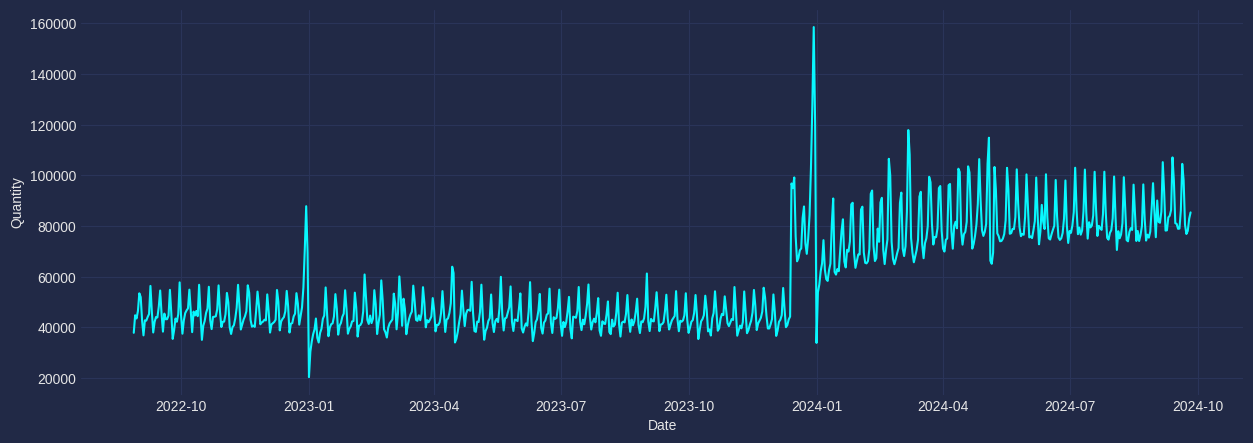

In [122]:
aux = df.groupby('date', as_index=False).quantity.sum()
plt.figure(figsize=(15,5))

sns.lineplot(aux, x='date', y='quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')

(<Figure size 1250x510 with 4 Axes>,
 array([<Axes: ylabel='2022'>, <Axes: ylabel='2023'>,
        <Axes: ylabel='2024'>], dtype=object))

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


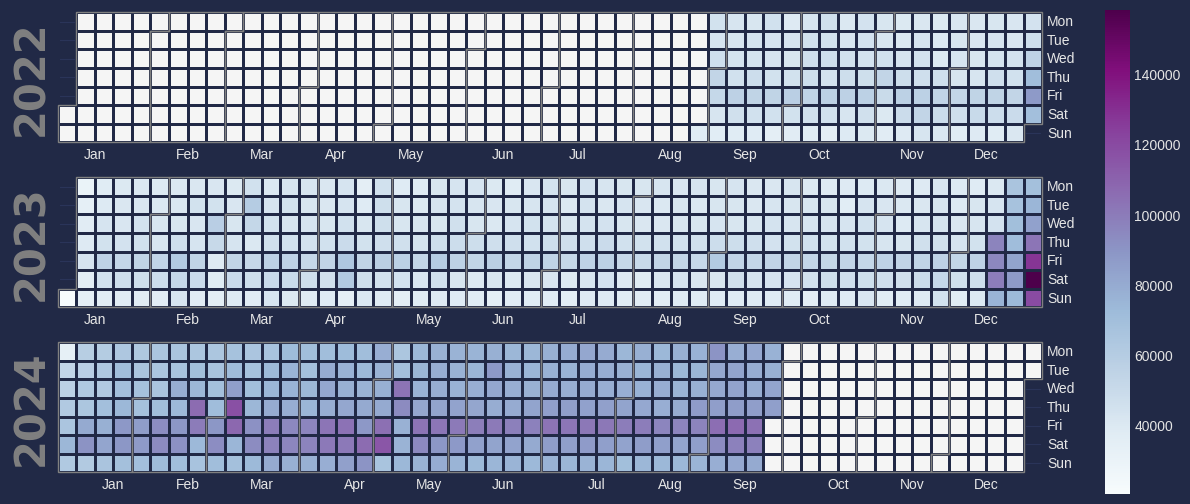

In [123]:
aux = df.groupby(['date']).quantity.sum()
clp(aux, cmap="BuPu")

# Số lượng (Quantity) theo cửa hàng(Store)

In [ ]:
colors =[
    '#08F7FE',
    '#FE53BB',
    '#F5D300',
    '#00ff41',
]

aux = df.groupby(['date', 'store_id'], as_index=False).quantity.sum()

plt.figure(figsize=(12,5))
for i in range(4):
    aux2=aux[aux.store_id == i+1]
    plt.plot(aux2.date, aux2.quantity, label=f"store{i+1}", color=colors[i])

plt.legend() #hiển thị chú thích 
plt.xlim(aux.date.min(), aux.date.max())
plt.xlabel('Date')
plt.ylabel('Quantity')

Text(0, 0.5, 'Quantity')

Text(0.5, 0, 'Quantity')

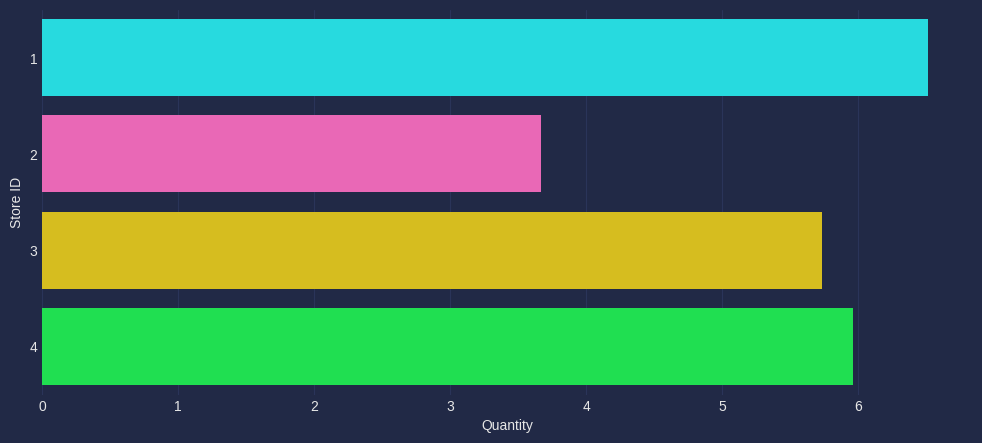

In [125]:
aux = df.groupby(['store_id'], as_index=False).quantity.mean()

aux.store_id = aux.store_id.apply(str) #chuyen sang kiểu chuỗi (string)

plt.figure(figsize=(12,5))
sns.barplot(data=aux, y='store_id', x='quantity', orient='h') # huong ngang

plt.ylabel('Store ID')
plt.xlabel('Quantity')

# Phân phối số lượng theo cửa hàng

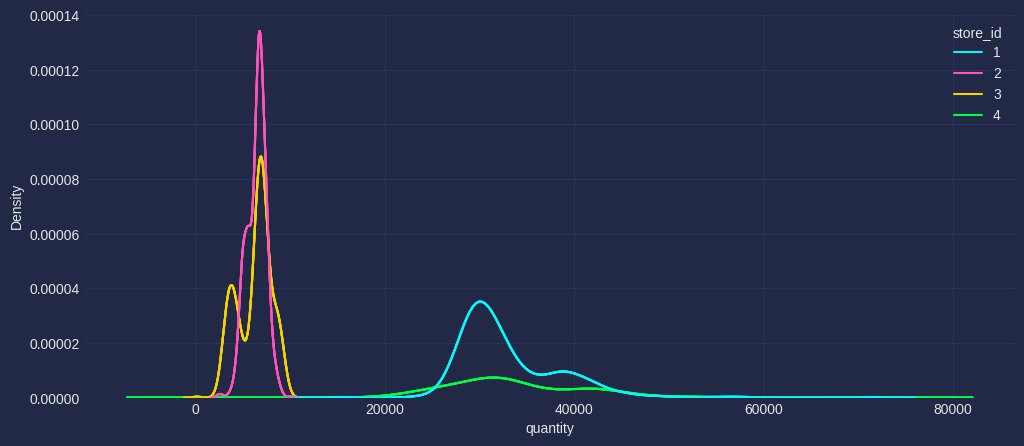

In [126]:
aux = df.groupby(['date', 'store_id'], as_index=False).quantity.sum()

plt.figure(figsize=(12,5))

for i in range(4):
    sns.kdeplot(aux , x='quantity', hue='store_id', palette=colors)
# hue='store_id' giúp biểu đồ phân biệt dữ liệu theo từng cửa hàng bằng màu sắc

# Chuẩn hóa phân phối số lượng

In [ ]:
aux= df.groupby(by=['date', 'store_id'], as_index=False).quantity.sum()

plt.figure(figsize=(12,5))

for i in range(4):
    aux2=aux[aux.store_id == i+1]
    k = aux2.quantity.median()
    plt.plot(aux2.date, aux2.quantity/k , label=f"store{i+1}", color=colors[i])

plt.legend()
plt.xlim(aux.date.min(), aux.date.max())
plt.xlabel('Date')
plt.ylabel('Quantity')
    

Text(0, 0.5, 'Quantity')

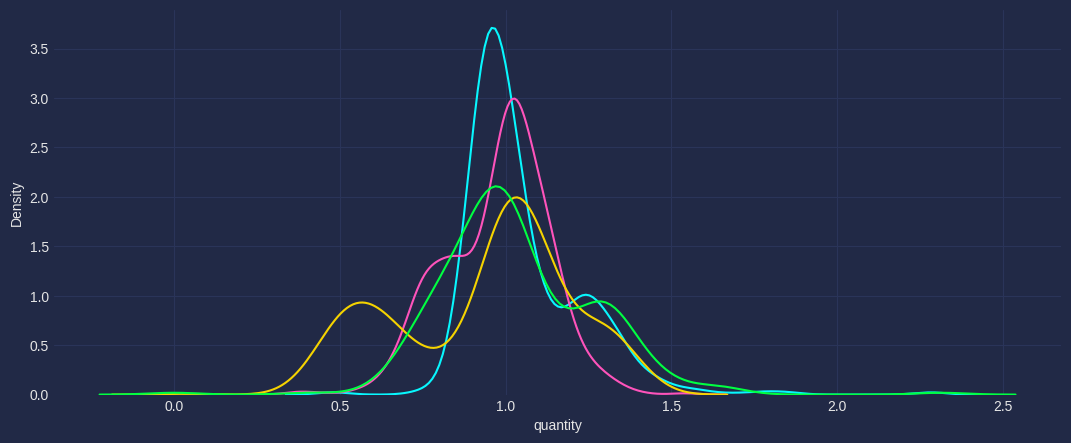

In [128]:
aux = df.groupby(by=['date', 'store_id'], as_index=False).quantity.sum()

plt.figure(figsize=(13,5))
for i in range(4):
    aux2 = aux[aux.store_id == i+1]
    k = aux2.quantity.median()
    sns.kdeplot(aux2.quantity/k, color=colors[i])

# Phân tích phân số

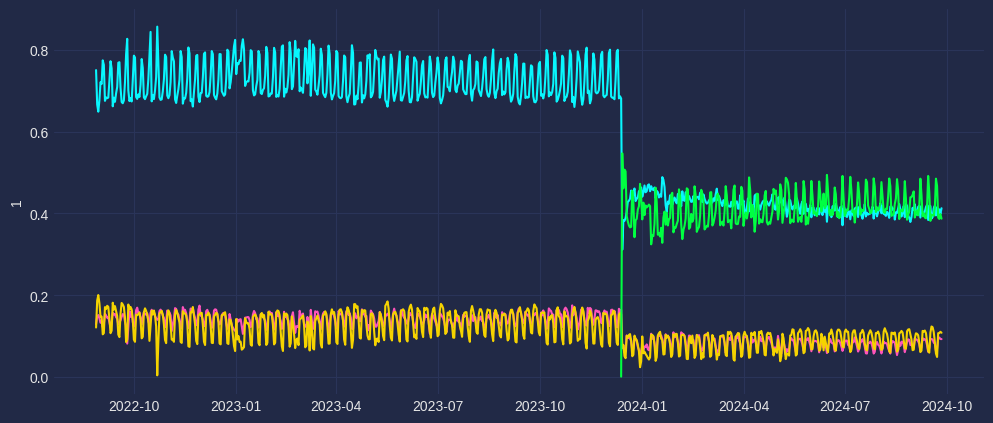

In [129]:
plt.figure(figsize=(12,5))
quantity_fractions = {}
quantity_per_column = df.groupby(['date', "store_id"])["quantity"].sum().reset_index().pivot(index="date", columns="store_id", values='quantity').reset_index(drop=True)
quantity_fractions["store_id"] = quantity_per_column.divide(quantity_per_column.sum(axis=1), axis=0)
for i in range(4):
    sns.lineplot(x=df.date.unique(), y=quantity_fractions["store_id"][i+1]);

# Quantity by item type

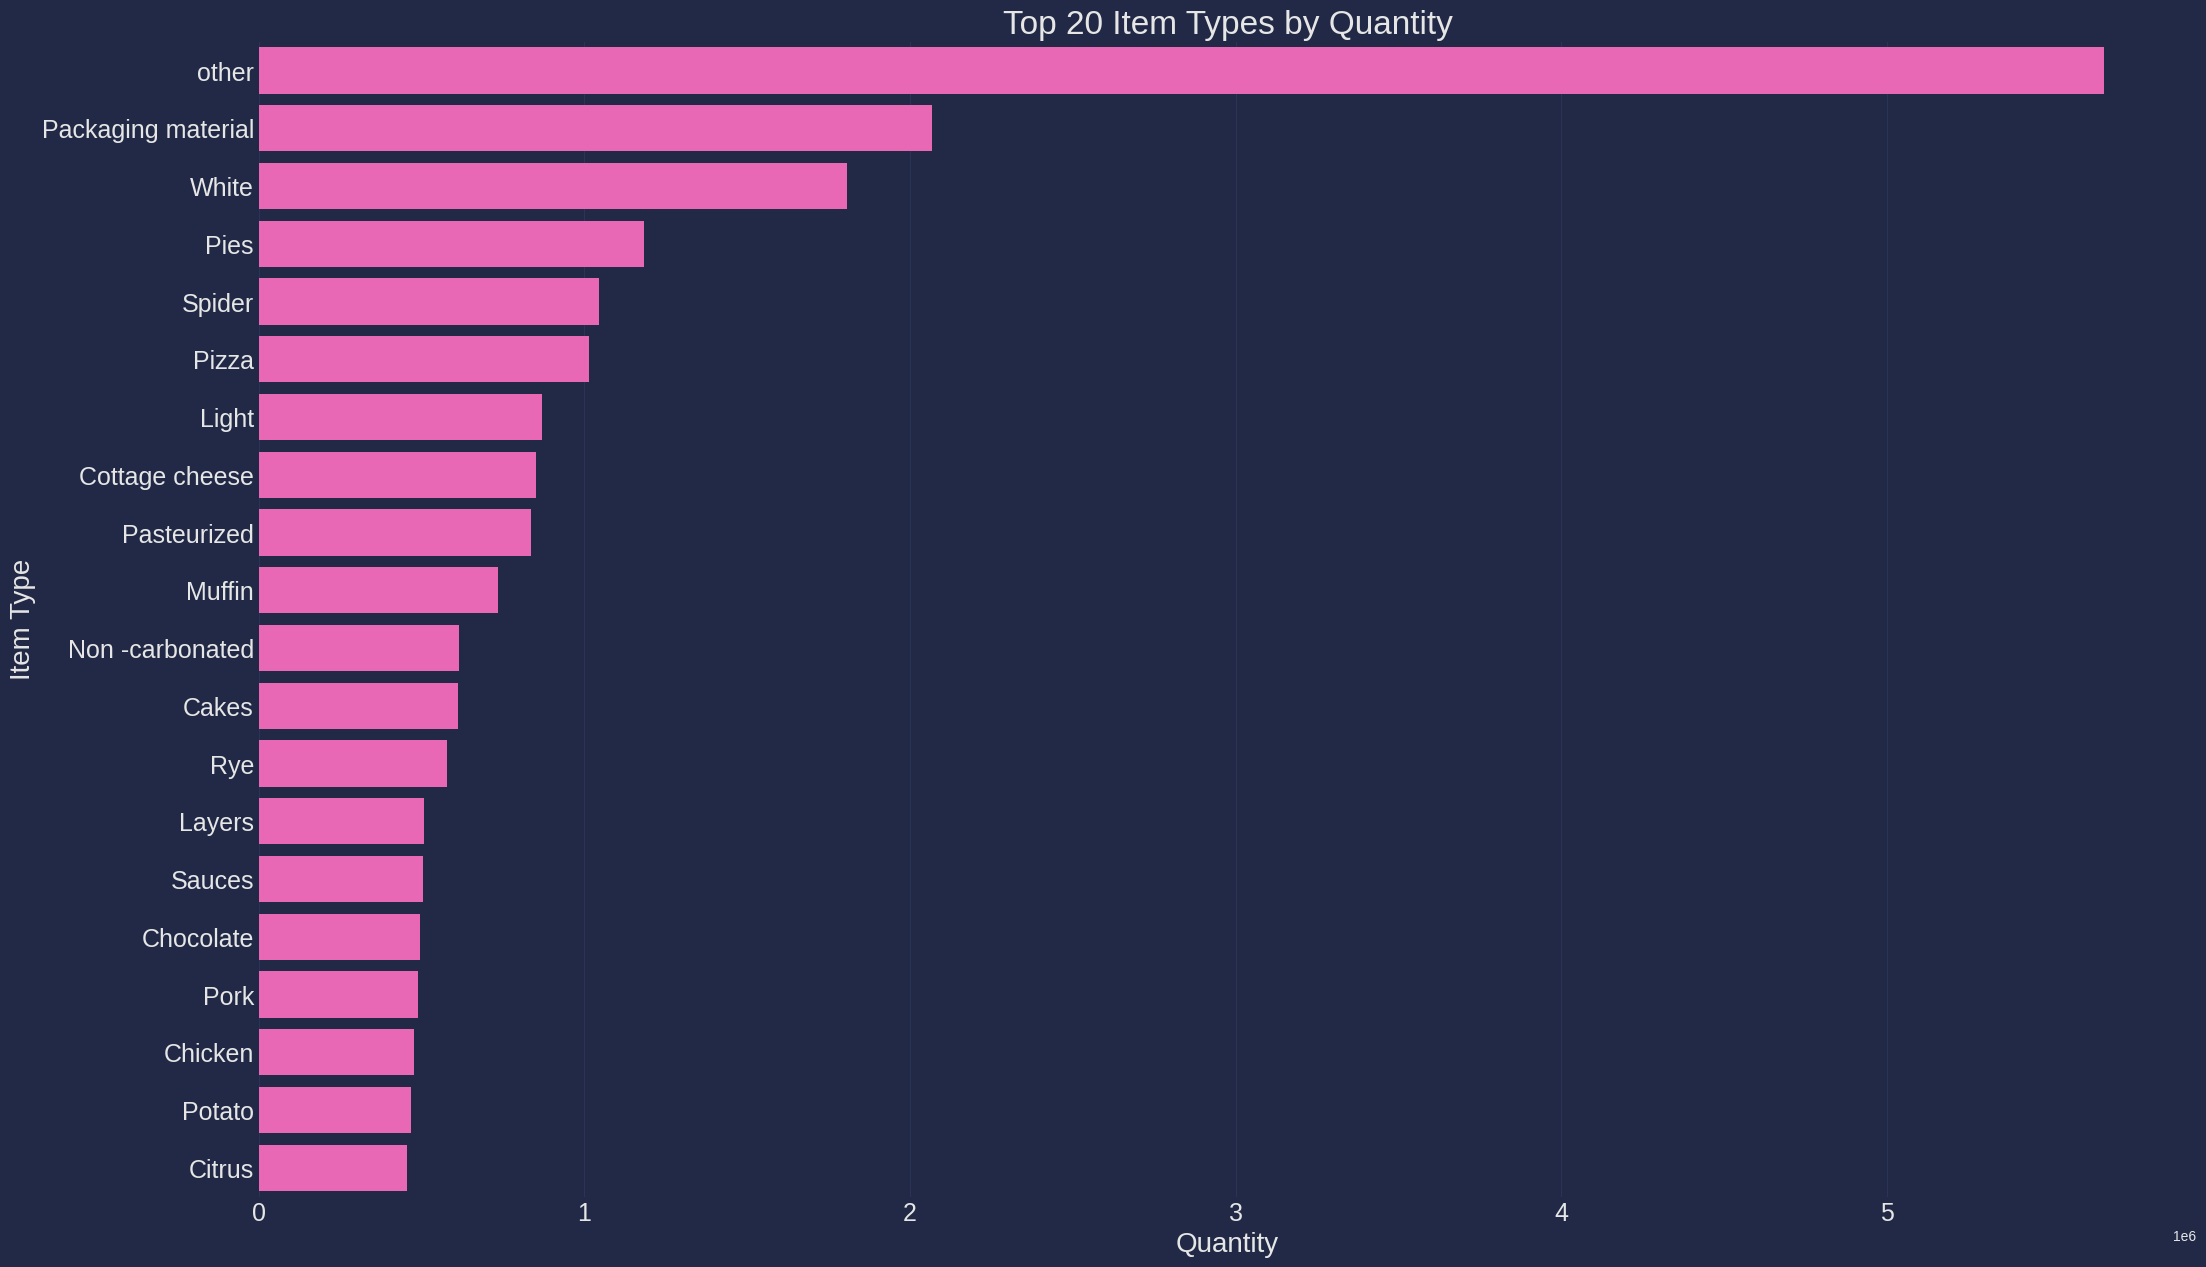

In [130]:
aux = df.groupby(["item_type"], as_index=False).quantity.sum().sort_values(by="quantity", ascending=False)[:20]

plt.figure(figsize=(25, 15))
sns.barplot(aux, y="item_type", x="quantity", color=colors[1]);

plt.xlabel("Quantity", fontsize=20)
plt.ylabel("Item Type", fontsize=20)
plt.title("Top 20 Item Types by Quantity", fontsize=24)

# Tăng cỡ chữ cho nhãn trục
plt.tick_params(axis='both', labelsize=18)


# Feature Engineering

## Trích xuất các tính năng của cột ngày

In [131]:
def date_features(dataframe):
    dataframe["dayofmonth"] = dataframe.date.dt.day
    dataframe["month"] = dataframe.date.dt.month
    dataframe["dayofyear"] = dataframe.date.dt.dayofyear
    dataframe["year"] = dataframe.date.dt.year
    dataframe['dayofweek'] = dataframe['date'].dt.dayofweek 
    dataframe['week'] = dataframe['date'].dt.isocalendar().week
    return dataframe
    
df = date_features(df)
df_test = date_features(df_test)

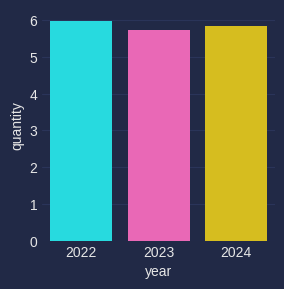

In [132]:
# Quantity per year
plt.figure(figsize=(3, 3))
aux = df.groupby(["year"]).quantity.mean().reset_index()
aux.year = aux.year.apply(str)
sns.barplot(y=aux.quantity, x=aux.year);

In [133]:
def transform2cyclic(dataframe):
    dataframe['dayofmonth_sin'] = np.sin(2 * np.pi * (dataframe['dayofmonth']-1)/31)
    dataframe['dayofmonth_cos'] = np.cos(2 * np.pi * (dataframe['dayofmonth']-1)/31)

    dataframe['dayofyear_sin'] = np.sin(2 * np.pi * (dataframe['dayofyear']-1)/365)
    dataframe['dayofyear_cos'] = np.cos(2 * np.pi * (dataframe['dayofyear']-1)/365)
    
    dataframe['dayofweek_sin'] = np.sin(2 * np.pi * dataframe['dayofweek']/6)
    dataframe['dayofweek_cos'] = np.cos(2 * np.pi * dataframe['dayofweek']/6)
    
    dataframe['week_sin'] = np.sin(2 * np.pi * (dataframe['week']-1)/52)
    dataframe['week_cos'] = np.cos(2 * np.pi * (dataframe['week']-1)/52)
    
    dataframe['month_sin'] = np.sin(2 * np.pi * (dataframe['month']-1)/12)
    dataframe['month_cos'] = np.cos(2 * np.pi * (dataframe['month']-1)/12)
    return dataframe

df = transform2cyclic(df)
df_test = transform2cyclic(df_test)

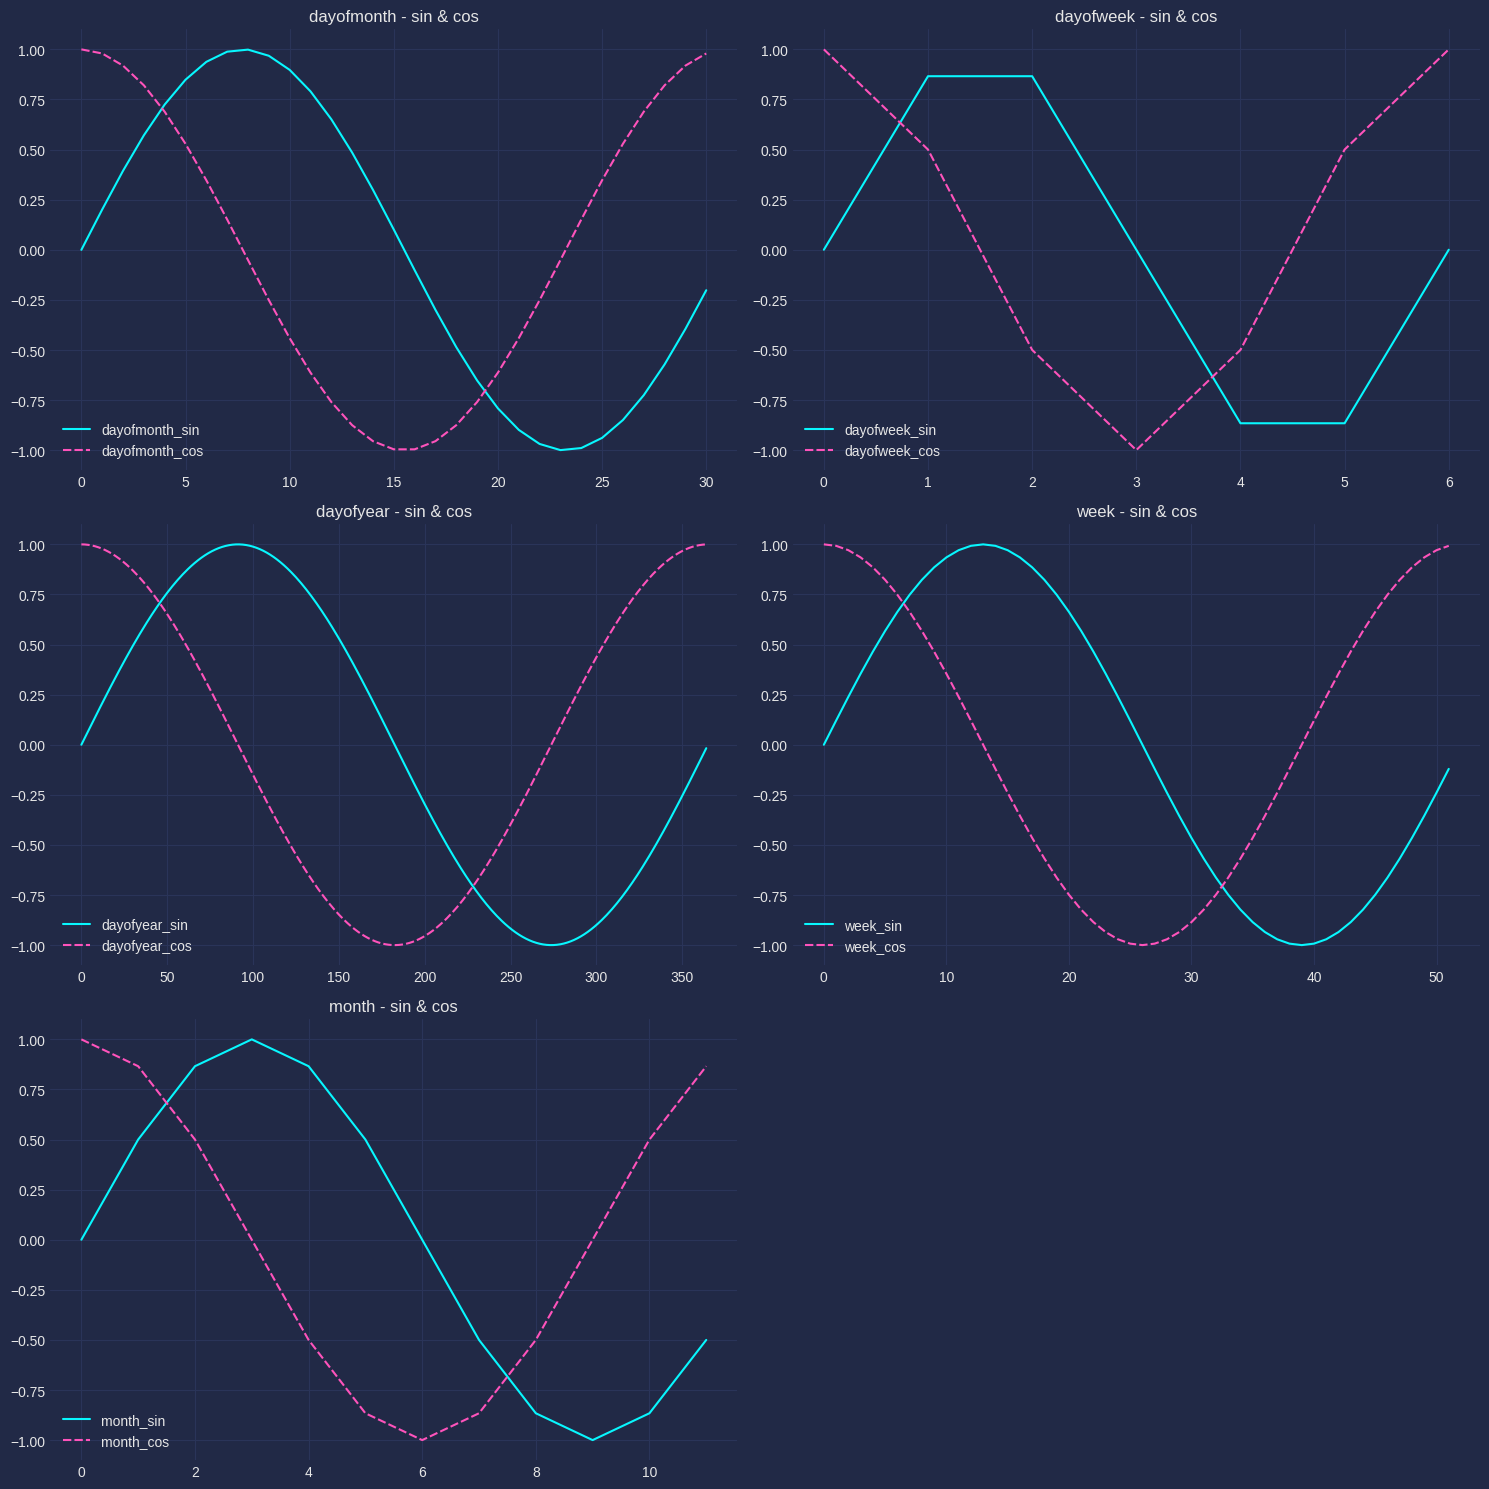

In [134]:
cols = ["dayofmonth", "dayofweek", "dayofyear", "week", "month"]
n = len(cols)
rows = (n + 1) // 2  # 2 plots per row

fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

for i, col in enumerate(cols):
    aux = df.groupby([col, col+"_sin", col+"_cos"]).quantity.mean().reset_index()
    aux[col] = aux[col].apply(str)
    sns.lineplot(data=aux[[col+"_sin", col+"_cos"]], ax=axes[i])
    axes[i].set_title(f"{col} - sin & cos")

# Hide any unused subplots (if n is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [135]:
def get_seasons(dataframe):
    dataframe["season"] = 0
    dataframe.loc[(dataframe.month >= 3) & (dataframe.month <= 5), "season"] = 1
    dataframe.loc[(dataframe.month >= 6) & (dataframe.month <= 8), "season"] = 2
    dataframe.loc[(dataframe.month == 9) & (dataframe.month <= 11), "season"] = 3
    dataframe.loc[((dataframe.month >= 1) & (dataframe.month <= 2)) | (dataframe.month == 12), "season"] = 4
    return dataframe

df = get_seasons(df)
df_test = get_seasons(df_test)

In [136]:
df.columns

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'discount_percentage', 'number_disc_day', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
       'dayofmonth', 'month', 'dayofyear', 'year', 'dayofweek', 'week',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'season'],
      dtype='object')

In [137]:
def get_holidays(dataframe):
    RU_holidays = holidays.CountryHoliday('RU', years=[2022, 2023, 2024])
    dataframe["holidays"] = False
    dataframe.loc[df.date.isin(RU_holidays.keys()), "holidays"] = True
    return dataframe

df = get_holidays(df)
df_test = get_holidays(df_test)

In [138]:
def get_sundays(dataframe):
    dataframe["is_sunday"] = dataframe['dayofweek'].eq(6)
    return dataframe

df = get_sundays(df)
df_test = get_sundays(df_test)

In [139]:
def get_weekends(dataframe):
    dataframe["is_weekend"] = dataframe['dayofweek'].isin([4, 5, 6])
    return dataframe

df = get_weekends(df)
df_test = get_weekends(df_test)

In [140]:
df.columns

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'discount_percentage', 'number_disc_day', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
       'dayofmonth', 'month', 'dayofyear', 'year', 'dayofweek', 'week',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'season', 'holidays', 'is_sunday', 'is_weekend'],
      dtype='object')

In [141]:
df_test.columns

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'discount_percentage', 'number_disc_day', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
       'dayofmonth', 'month', 'dayofyear', 'year', 'dayofweek', 'week',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'season', 'holidays', 'is_sunday', 'is_weekend'],
      dtype='object')

In [142]:
cols = ['date', 
        'dayofmonth', 
        'dayofyear',
        'dayofweek', 
        'week', 
        'online',
        'is_available',
        'month', 
        'price_base_both', 
        'sum_total_both',
        'price'
       ]
df.drop(columns=cols, inplace=True)
df_test.drop(columns=cols+["quantity"], inplace=True)

In [143]:
df_test.columns

Index(['item_id', 'store_id', 'division', 'city', 'discount_percentage',
       'number_disc_day', 'dept_name', 'class_name', 'subclass_name',
       'item_type', 'weight_volume', 'weight_netto', 'year', 'dayofmonth_sin',
       'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin',
       'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos',
       'season', 'holidays', 'is_sunday', 'is_weekend'],
      dtype='object')

In [144]:
X = df.drop(["quantity"], axis=1)
y = df["quantity"]

In [145]:
numerical_cols = X.select_dtypes([np.int32, np.int64, np.float32, np.float64]).columns.to_list()
categorical_cols = X.select_dtypes('object').columns.to_list()
numerical_cols, categorical_cols

(['store_id',
  'discount_percentage',
  'number_disc_day',
  'weight_volume',
  'weight_netto',
  'year',
  'dayofmonth_sin',
  'dayofmonth_cos',
  'dayofyear_sin',
  'dayofyear_cos',
  'dayofweek_sin',
  'dayofweek_cos',
  'week_sin',
  'week_cos',
  'month_sin',
  'month_cos',
  'season'],
 ['item_id',
  'division',
  'city',
  'dept_name',
  'class_name',
  'subclass_name',
  'item_type'])

In [146]:
column_transformer = make_column_transformer(
    # Numerical columns
    (
        StandardScaler(),
        numerical_cols
    ),
    # Categorical columns
    (
        OneHotEncoder(handle_unknown='ignore', drop='first'),
        categorical_cols
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_transformed = column_transformer.fit_transform(X)
X_test_transformed = column_transformer.transform(df_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [147]:
seed_value = 42
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, train_size=0.8, random_state=seed_value)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6112579, 30376) (6112579,)
(1528145, 30376) (1528145,)


In [148]:
import optuna
import numpy as np
import joblib
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# 1. Hàm objective cho Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 10000),
        'learning_rate': trial.suggest_float('learning_rate', 0.3, 0.6),
        'depth': trial.suggest_int('depth', 10, 14),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 0.1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.0),
        'langevin': True,
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': False
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=20
    )

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    # Lưu model tốt nhất nếu RMSE cải thiện
    if rmse < objective.best_rmse:
        joblib.dump(model, "best_model_catboost.pkl")
        objective.best_rmse = rmse

    return rmse

# Gán giá trị RMSE ban đầu lớn nhất
objective.best_rmse = float("inf")

# 2. Tối ưu với Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=3600)

print(" Best params:", study.best_params)
print(" Best RMSE:", study.best_value)

# 3. Load model tốt nhất và dự đoán
best_model = joblib.load("best_model_catboost.pkl")

# Dự đoán trên tập test
quantity_pred = best_model.predict(X_test_transformed)

# 4. Tạo submission
df_test["quantity"] = quantity_pred
df_submission = df_test[["quantity"]]

# Xem trước kết quả
print(df_submission.head())


[I 2025-05-25 05:55:02,019] A new study created in memory with name: no-name-83e5de6b-00e3-4c97-b4d5-d279a909ebe5
[I 2025-05-25 07:29:24,264] Trial 0 finished with value: 6.280863158144265 and parameters: {'iterations': 5798, 'learning_rate': 0.5697635693353184, 'depth': 14, 'l2_leaf_reg': 2.2961341417774364, 'random_strength': 0.0031531723016861137, 'bagging_temperature': 0.5217322658102939}. Best is trial 0 with value: 6.280863158144265.


 Best params: {'iterations': 5798, 'learning_rate': 0.5697635693353184, 'depth': 14, 'l2_leaf_reg': 2.2961341417774364, 'random_strength': 0.0031531723016861137, 'bagging_temperature': 0.5217322658102939}
 Best RMSE: 6.280863158144265
   quantity
0    6.3823
1    5.6930
2    5.6563
3    4.9427
4    4.9900


In [149]:
missing_items = df_test[~df_test.item_id.isin(df.item_id)]
missing_items.head()

,item_id,store_id,division,city,discount_percentage,number_disc_day,dept_name,class_name,subclass_name,item_type,...,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,season,holidays,is_sunday,is_weekend,quantity
12750,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,-0.5000,-0.9927,-0.1205,-0.8660,-0.5000,3,False,False,True,4.0141
12751,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,0.5000,-0.9927,-0.1205,-0.8660,-0.5000,3,False,False,True,3.4075
12752,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,1.0000,-0.9927,-0.1205,-0.8660,-0.5000,3,False,True,True,3.2239
12753,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,1.0000,-1.0000,-0.0000,-0.8660,-0.5000,3,False,False,False,2.9149
12754,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,0.5000,-1.0000,-0.0000,-1.0000,-0.0000,0,False,False,False,2.9621


In [150]:
df_submission.loc[missing_items.index, "quantity"] = 0

/tmp/ipykernel_35/1049873960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission.loc[missing_items.index, "quantity"] = 0


In [151]:
df_submission.to_csv("/kaggle/working/submission.csv", index_label='row_id')